In [ ]:
# colab = True 

# import os 

# if colab:
#     !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
#     os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 2')

# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante: Paloma Sette

Base de dados: s_vendas_espumante.csv

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm

## Preparação para a lista

In [2]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [3]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    """ 
    Em termos matemáticos, o retorno do método forward
    se refere à y = W2 · f(W1 · x + b1) + b2
    """
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

In [6]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

### Entendendo o funcionamento da função `transform_data()`

Imaginando uma série temporal de **vendas mensais** junto com o número do mês, por exemplo:

| Vendas (`y`) | Mês (`month`) |
|--------------|---------------|
| 120          | 1             |
| 130          | 2             |
| 150          | 3             |
| 170          | 4             |
| 160          | 5             |
| 180          | 6             |
| 200          | 7             |
| 210          | 8             |

Chamamos a função:

```python
transform_data(data=df, lag=2, test_split=0.25, normalize=True, category='binary')
```

🔹 `lag = 2` → queremos usar dois valores passados como entrada  
🔹 `test_split = 0.25` → os últimos 25% dos dados (2 meses) serão usados como teste  
🔹 `normalize = True` → os dados de vendas serão normalizados entre 0 e 1  
🔹 `category = 'binary'` → o mês será codificado em 4 bits binários (`month_0` a `month_3`)

---

### Etapas realizadas pela função:

1. Divide os dados em treino e teste, usando os últimos registros para generalização
2. Normaliza os dados com base apenas nos valores de treino
3. Constrói janelas deslizantes do tipo:

    **Entrada**:  $[y(t-2), y(t-1)]$  
    **Saída**:    $[y(t), y(t+1)]$

4. Codifica o mês em binário puro de 4 bits.  
   Por exemplo, mês 4 vira:

```text
0100  →  [0, 1, 0, 0]
```

---

### Saída

A função retorna dois DataFrames:

- `new_train_df`: com as janelas de treino
- `new_test_df`: com as janelas de teste

Cada linha terá:

- Colunas com o mês binário (ex: `month_0`, ..., `month_3`)
- Os valores da série: `y(t-2)`, `y(t-1)`, `y(t)`, `y(t+1)`

Esses dados estão prontos para alimentar uma MLP para prever o próximo valor da série.


In [7]:
""" 
OBS.: Estou utilizando o meu username no link porque fiz o fork do repositório original. 
"""

dataset_name = 'vendas_espumante'
path = f'https://raw.githubusercontent.com/palomaflsette/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)


## Parte I - Compreensão do problema

Total: 3,0 pts.

#### 1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

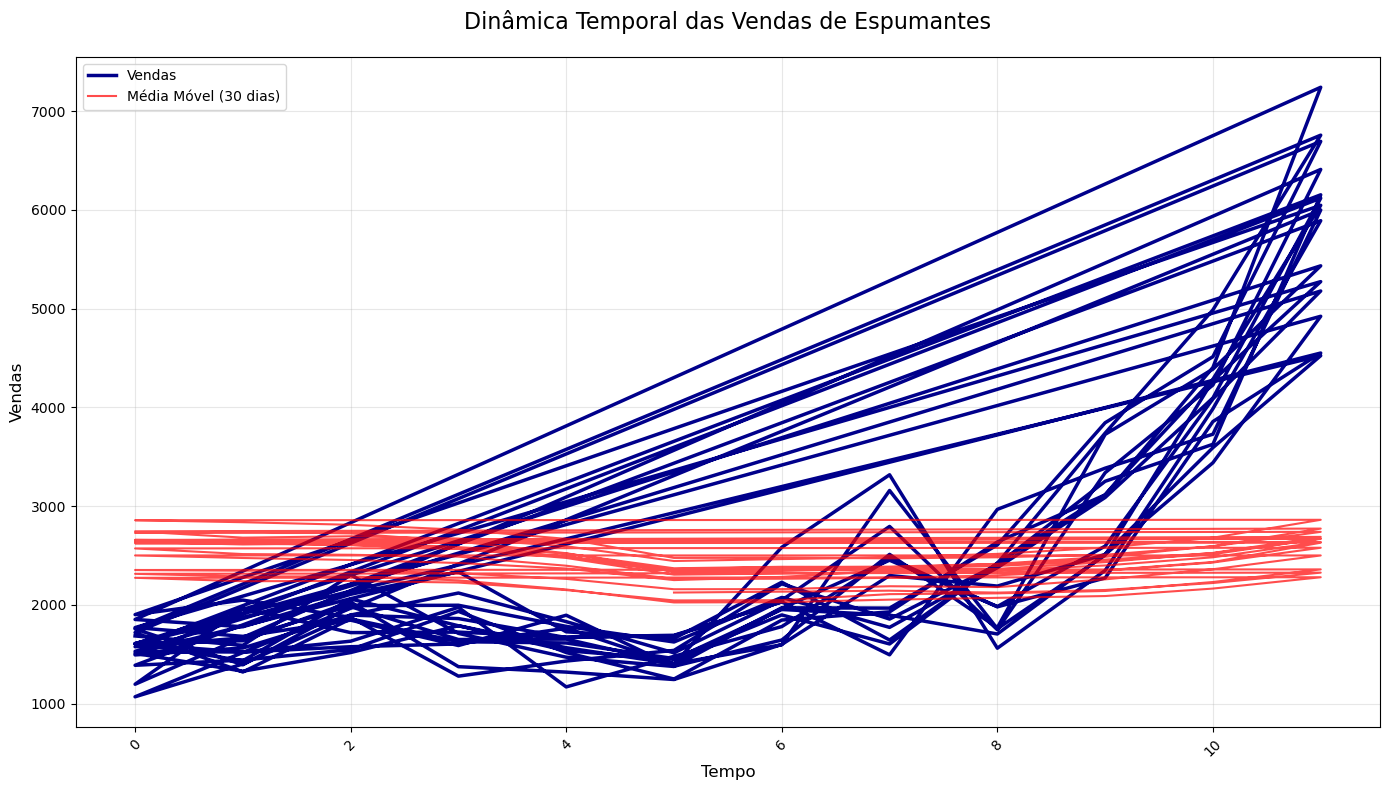

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(raw_data['time'], raw_data['value'],
        linewidth=2.5, color='darkblue', label='Vendas')

raw_data['ma_30'] = raw_data['value'].rolling(window=30).mean()
ax.plot(raw_data['time'], raw_data['ma_30'],
        linewidth=1.5, color='red', alpha=0.7, label='Média Móvel (30 dias)')

ax.set_title('Dinâmica Temporal das Vendas de Espumantes', fontsize=16, pad=20)
ax.set_xlabel('Tempo', fontsize=12)
ax.set_ylabel('Vendas', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

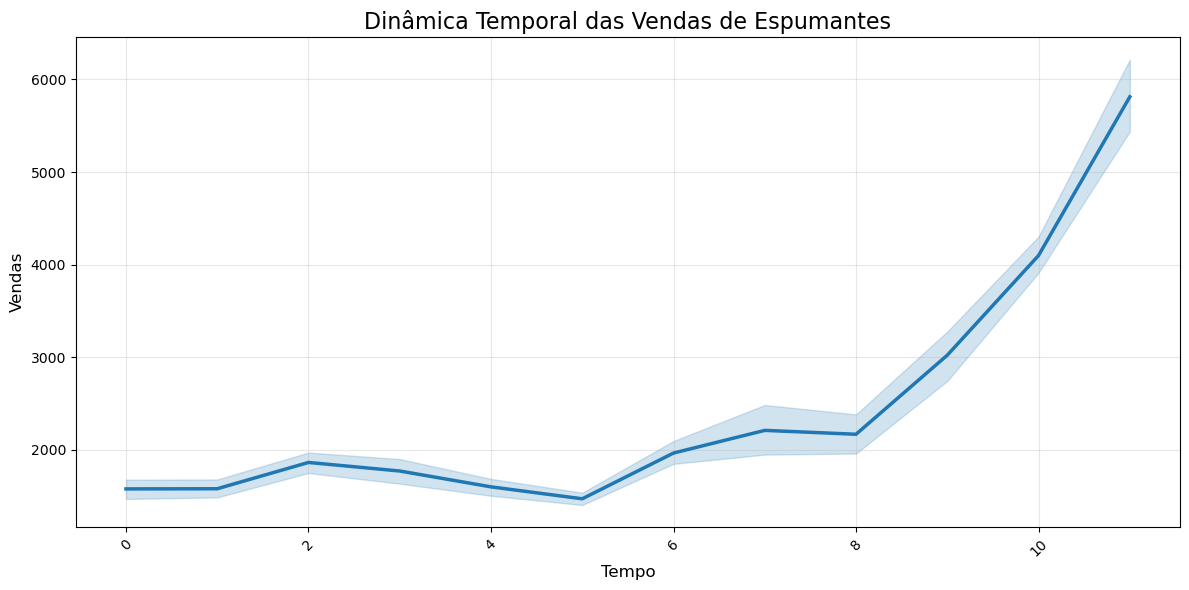

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=raw_data, x='time', y='value', linewidth=2.5)
plt.title('Dinâmica Temporal das Vendas de Espumantes', fontsize=16)
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Vendas', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)

plt.show()

##### **Análise Série Temporal**

A série analisada representa as vendas mensais de espumantes ao longo de múltiplos meses. A visualização gráfica revelou comportamentos consistentes com dados reais de consumo cíclico e sazonal, com os seguintes padrões:

###### **Características observadas**:

- **Tendência crescente**: há uma elevação significativa das vendas ao longo dos anos, sobretudo nos meses finais (outubro a dezembro).
- **Sazonalidade clara**: os picos de vendas são consistentes, especialmente no fim do ano, refletindo eventos como Natal e Ano Novo.
- **Volatilidade significativa**: observa-se alta variabilidade na amplitude dos picos sazonais, o que sugere que a variância da série não é constante.
- **Não-estacionariedade**: a média e a variância da série mudam ao longo do tempo, o que pode comprometer o desempenho de modelos sem memória explícita.

---

###### **É adequada para Redes Neurais?**

**Sim**, especialmente após um pipeline de pré-processamento apropriado. As RNs são modelos tolerantes a não linearidades e ruído, e têm capacidade de capturar padrões sazonais complexos. No entanto, sem ajustes, a presença de tendência e variância não constante pode levar a:

- **Overfitting nos picos recentes** ;
- **Aprendizado distorcido de padrões de base**;
- **Problemas de convergência** durante o treinamento.

---

###### **Então, algumas técnicas de Pré-Processamento Recomendadas**

Relacionamos as características observadas na série com as técnicas propostas e seu efeito esperado no treinamento de uma RNA:

| Problema observado              | Técnica sugerida                                      | Efeito sobre o modelo                                  |
|-------------------------------|--------------------------------------------------------|--------------------------------------------------------|
| Variância crescente            | 🔹 Transformação Logarítmica<br>🔹 Box-Cox            | Reduz picos desproporcionais, estabiliza escala       |
| Tendência de longo prazo      | 🔹 Diferenciação<br>🔹 `detrend()`                    | Remove viés crescente, ajuda em generalização          |
| Escalas incompatíveis         | 🔹 `MinMaxScaler`<br>🔹 `StandardScaler`              | Facilita aprendizado em funções de ativação (ReLU, tanh) |
| Ruído nos dados               | 🔹 Média móvel<br>🔹 Suavização exponencial           | Reduz flutuação local, melhora estabilidade do modelo  |
| Padrões sazonais dominantes   | 🔹 Decomposição Sazonal<br>🔹 Inserção do mês (exógeno)| Explicita regularidade anual, melhora previsão cíclica |

---

###### **Relacionando com os gráficos gerados**

1. O **gráfico das curvas anuais sobrepostas** mostra a sazonalidade clara e a escalada de pico nos últimos anos, o que justifica a aplicação de **Box-Cox** e **codificação exógena do mês** para capturar esse comportamento com uma MLP.
2. O **gráfico da média mensal com desvio** evidencia **não estacionariedade de segunda ordem** (variância), especialmente de outubro a dezembro, reforçando a necessidade de **suavização** e **normalização**.

---


Portanto, a série de vendas de espumantes é um **caso clássico de previsão com dependência temporal e sazonalidade**, sendo altamente compatível com Redes Neurais como MLPs (com janela deslizante e variáveis exógenas) ou ESNs/LSTMs.
Contudo, para alcançar uma modelagem consistente e generalizável, é essencial aplicar um pipeline de pré-processamento com:

- **Estabilização da variância**
- **Remoção de tendência**
- **Escalonamento**
- **Suavização**
- **Inserção de variáveis sazonais codificadas**

Essas práticas alinham os dados com os requisitos computacionais e matemáticos de aprendizado profundo, transformando uma série bruta em uma estrutura informacionalmente rica e tratável.

1.1.1 **Estabilização da Variância**

Transformação logarítmica:

In [10]:
vendas_log = np.log(raw_data['value'])

1.1.2 **Remoção de Tendência**

Diferenciação:

In [11]:

vendas_diff = vendas_log.diff().dropna()


1.1.3 **Suavização**

In [12]:
vendas_diff_smooth = np.convolve(vendas_diff.values, np.ones(3)/3, mode='same')

1.1.4 **Normalização/Padronização**

In [13]:

""" z-score"""
scaler = StandardScaler()
vendas_final = scaler.fit_transform(vendas_diff_smooth.reshape(-1, 1))

In [14]:
vendas_final

array([[ 0.48560234],
       [ 0.0203401 ],
       [-0.1264895 ],
       [-0.81003655],
       [ 0.21308988],
       [ 0.7974876 ],
       [ 0.5685078 ],
       [ 0.43184042],
       [ 0.79612482],
       [ 1.499534  ],
       [-0.8319137 ],
       [-1.55009226],
       [-1.81181837],
       [ 0.39711796],
       [-0.41671869],
       [-0.15775366],
       [-0.1664059 ],
       [ 1.16823556],
       [ 0.45312909],
       [ 0.37850442],
       [ 0.69329601],
       [ 1.29939536],
       [-0.64436848],
       [-1.67281162],
       [-1.72371179],
       [ 0.2628571 ],
       [ 0.2241611 ],
       [-0.07651382],
       [ 0.13370007],
       [ 0.32604718],
       [ 0.25215992],
       [ 0.39114865],
       [ 0.99698821],
       [ 1.52420536],
       [-0.70275858],
       [-1.23423378],
       [-1.25906355],
       [-0.24984344],
       [-0.3417808 ],
       [-0.76955621],
       [ 0.23378676],
       [ 0.86491204],
       [ 0.88185519],
       [ 0.7024064 ],
       [ 0.62839112],
       [ 1

#### 2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

Quando nos debruçamos sobre a dinâmica complexa de séries temporais como as vendas de espumantes, que notoriamente exibem um forte componente sazonal, a inclusão de uma variável exógena que indica o mês de previsão (t+1) não é apenas um detalhe técnico; mas tamb´m uma necessidade estratégica. Sua contribuição se manifesta em múltiplas dimensões, cada qual fundamental para a consistência e acurácia do modelo preditivo.

1. **Decodificando a Sazonalidade: Um Atalho Cognitivo para a Rede**

Pensemos na série de vendas de espumantes: picos anuais em momentos específicos do calendário, como Natal e Ano Novo, são mais do que meras flutuações; são fenômenos comerciais profundamente enraizados em ciclos sociais. Ao entregar à rede neural (particularmente uma MLP, que carece de memória intrínseca de sequências) a informação explícita do "mês de previsão", estamos lhe oferecendo um atalho cognitivo crucial.

Em vez de forçar o modelo a "inferir" um ciclo de 12 meses, muitas vezes de forma ineficiente ou através de janelas de `lag` longas e custosas, ele passa a ter uma pista direta sobre o contexto sazonal futuro.
Isso significa que a rede pode aprender a associar diretamente o mês de dezembro a um padrão de vendas elevado, independentemente de os meses anteriores terem sido de baixa demanda. É como dar a um estudante uma "cola" sobre o período do ano, permitindo-lhe antecipar o comportamento sem ter que deduzi-lo cada vez do zero.

----


2. **Refinando a Precisão Preditiva: Antecipando o Comportamento Sazonal**

O poder de "saber" o mês futuro se traduz diretamente em uma capacidade preditiva superior. Se o modelo está prestes a prever as vendas de um Dezembro, e essa informação está explicitamente disponível, ele pode calibrar sua saída para refletir a expectativa de um pico.

Mesmo que os dados dos últimos meses (via lags) sugiram uma estabilidade ou queda temporária, o conhecimento do mês vindouro permite que a rede "salte" para uma previsão mais audaciosa e realista, característica de um período de alta demanda.
Isso minimiza consideravelmente os erros sistemáticos que poderiam surgir de uma rede "cega" à sazonalidade, levando a previsões subestimadas em picos ou superestimadas em vales.

----
3. **Gerenciando a Volatilidade Sazonal: Lidando com a Heterocedasticidade** 

 Nossa análise preliminar já indicou que a série não é estacionária, e um ponto crítico é a variância sazonal ,os picos tendem a ser mais voláteis. Fornecer o mês como uma variável exógena permite que o modelo desenvolva uma sensibilidade a essa dinâmica.

A rede pode, em essência, aprender a "esperar" maior dispersão ou oscilação nos resultados de previsão para determinados meses (como dezembro) e ajustar suas estimativas de acordo.
Essa capacidade de modular a resposta em função da estrutura estatística intrínseca de cada mês torna o modelo mais resiliente e adaptável às mudanças de regime de volatilidade, melhorando sua robustez global.

----


4. **Ampliando o Horizonte Temporal do Lag: Contexto Além da Janela**

 Embora a janela de lag (histórico recente da série) seja fundamental para capturar as dependências temporais imediatas, ela muitas vezes se torna ineficaz para ciclos longos, como o período de 12 meses. Limitações computacionais ou o risco de overfitting podem restringir o tamanho dessa janela.

A variável do mês atua como uma âncora temporal essencial, fornecendo o contexto global do ciclo anual para o instante de previsão. Ela preenche as lacunas que um lag curto poderia deixar, garantindo que o modelo sempre "saiba" onde está no tempo anual, independentemente de quão longe no passado ele "olha" em detalhes. É um complemento que amplia o alcance efetivo da memória do modelo.

----

5. **Decomposição Inteligente de Efeitos: Isolando a Influência Sazonal** 

 Ao codificar o mês (seja via codificação binária, como a função transform_data parece sugerir, ou one-hot encoding), não estamos apenas inserindo um número; estamos permitindo que o modelo aprenda pesos específicos para cada mês. 
Na prática, isso permite uma decomposição implícita do sinal. A rede pode aprender a separar o efeito sazonal de outros componentes da série, como a tendência de longo prazo ou o ruído aleatório.
Essa capacidade de isolar influências não apenas aprimora a interpretabilidade (ainda que de forma limitada para MLPs), mas, crucialmente, aumenta a capacidade de generalização do modelo. Ele se torna menos propenso a misturar padrões, conseguindo aplicar a lógica sazonal correta mesmo diante de variações anômalas em outros componentes da série.

----

**Uma Perspectiva Final**

A variável exógena do mês de previsão (t+1) não é um mero adendo. Ela é uma ferramenta analítica poderosa que confere à rede neural uma inteligência contextual indispensável para lidar com a complexidade das séries temporais sazonais. Sua inclusão transcende a simples otimização de uma métrica; ela dota o modelo de uma capacidade superior de contextualização, resiliência à não-estacionariedade e, em última análise, de uma confiabilidade preditiva que seria inatingível sem tal informação explícita. Para um problema como a previsão de vendas de espumantes, ignorar essa variável seria uma deficiência metodológica significativa.

#### 3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.


A base original de vendas de espumantes, apesar de conter dados importantes,
não está pronta para ser usada diretamente em um modelo MLP (Perceptron Multicamadas).
Esse tipo de rede exige que as entradas sejam vetores fixos e supervisionados,
o que nos obriga a montar um pipeline de pré-processamento adequado.

A seguir, detalhamos as etapas necessárias para tornar a base compatível com esse tipo de modelo:

------------------------------------------------------------

**1. Seleção e organização dos dados**

Requisitos mínimos:

- Série temporal univariada (ex: vendas mensais)
- Índice temporal ordenado (ex: datas ou meses numerados)

É importante:
- Remover valores ausentes
- Eliminar duplicatas
- Garantir a ordem cronológica correta

------------------------------------------------------------

**2. Estabilização estatística (opcional)**

Recomendada se houver:

- Variação de amplitude ao longo do tempo
- Picos atípicos ou crescimento exponencial

Possíveis transformações:
- Logaritmo ou Box-Cox
- Diferença de primeira ordem (para remover tendência)
- Suavização por média móvel (para ruído)

------------------------------------------------------------

**3. Normalização dos valores**

Essencial para o bom desempenho da MLP.

Opções mais comuns:
- Min-Max Scaling => recomendado para ReLU/sigmoid
- Z-score => recomendado para tanh

É importante sempre calcular os parâmetros da normalização com base APENAS no conjunto de treino.

------------------------------------------------------------

**4. Transformação em janelas supervisionadas (lag input)**

Como a MLP não tem memória, o histórico precisa ser fornecido como entrada.

Exemplo:
  - Entrada (X): $y(t−lag), ..., y(t−1)$
  - Saída  (y):  $y(t)$

Esse formato transforma o problema em uma regressão supervisionada com pares entrada-saída.

------------------------------------------------------------

**5. Inclusão de variáveis exógenas (opcional)**

No caso dos espumantes, incluir o mês da previsão ajuda a captar sazonalidade.

Formas de codificar:
- Binária simples
- One-hot encoding (mais comum)

Isso permite que o modelo reconheça padrões como aumento de vendas em dezembro.

------------------------------------------------------------

**6. Separação entre treino e teste**

- Treino: dados antigos (usados para aprender)
- Teste: dados futuros (usados para avaliar)

A ordem temporal precisa ser mantida.

------------------------------------------------------------

Então, Com todos esses cuidados, que são limpeza, transformação, normalização, janelas e variáveis sazonais,
a base estará pronta para treinar uma MLP que aprenda padrões históricos com clareza.
Assim, o modelo conseguirá prever com mais confiança variações e sazonalidades das vendas de espumantes.


## Parte 2 - Previsão one-step

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula. 
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### 1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

Nesta etapa, avaliamos o desempenho de uma rede MLP na tarefa de previsão one-step da série de vendas de espumantes. Para isso, executamos o mesmo modelo em **dois cenários distintos**: utilizando a série **em sua forma original (raw)** e após um **pipeline completo de pré-processamento estatístico**.


🔹 **Cenário 1: Série original (`raw_data`) sem ajustes**

- Dados usados diretamente da base original
- `lag = 12`, com inclusão do mês como variável exógena
- Normalização padrão (MinMax)
- Rede: MLP com 20 neurônios ocultos e ativação sigmoide


In [15]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')




In [16]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.084980,0.069335,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136
1,0.0,0.0,1.0,0.0,0.069335,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252
2,0.0,0.0,1.0,1.0,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740
3,0.0,1.0,0.0,0.0,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740,0.000000
4,0.0,1.0,0.0,1.0,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740,0.000000,0.051054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.0,0.0,1.0,0.0,0.064888,0.119895,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580
158,0.0,0.0,1.0,1.0,0.119895,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403
159,0.0,1.0,0.0,0.0,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004
160,0.0,1.0,0.0,1.0,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133


In [17]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,1.0,1.0,1.0,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524
1,1.0,0.0,0.0,0.0,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113
2,1.0,0.0,0.0,1.0,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789
3,1.0,0.0,1.0,0.0,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443
4,1.0,0.0,1.0,1.0,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290
5,0.0,0.0,0.0,0.0,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290,-0.016469
6,0.0,0.0,0.0,1.0,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290,-0.016469,0.038208
7,0.0,0.0,1.0,0.0,0.131423,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290,-0.016469,0.038208,0.119730
8,0.0,0.0,1.0,1.0,0.090580,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290,-0.016469,0.038208,0.119730,0.113966
9,0.0,1.0,0.0,0.0,0.091403,0.083004,0.086133,0.141798,0.053524,0.296113,0.364789,0.421443,0.795290,-0.016469,0.038208,0.119730,0.113966,0.082345


In [18]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [19]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [20]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [22]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  6%|▌         | 61/1000 [00:00<00:04, 198.75it/s]

Epoch 51/1000, Loss: 0.0073


 12%|█▏        | 124/1000 [00:00<00:05, 172.69it/s]

Epoch 101/1000, Loss: 0.0007


 19%|█▉        | 189/1000 [00:01<00:04, 198.50it/s]

Epoch 151/1000, Loss: 0.0005


 23%|██▎       | 232/1000 [00:01<00:03, 203.26it/s]

Epoch 201/1000, Loss: 0.0005


 27%|██▋       | 274/1000 [00:01<00:04, 180.92it/s]

Epoch 251/1000, Loss: 0.0003


 34%|███▍      | 340/1000 [00:01<00:03, 203.01it/s]

Epoch 301/1000, Loss: 0.0002


 38%|███▊      | 383/1000 [00:02<00:02, 207.95it/s]

Epoch 351/1000, Loss: 0.0002


 43%|████▎     | 426/1000 [00:02<00:02, 206.26it/s]

Epoch 401/1000, Loss: 0.0001


 49%|████▉     | 489/1000 [00:02<00:02, 200.42it/s]

Epoch 451/1000, Loss: 0.0001


 51%|█████     | 510/1000 [00:02<00:02, 181.30it/s]

Epoch 501/1000, Loss: 0.0001


 56%|█████▋    | 565/1000 [00:03<00:02, 156.67it/s]

Epoch 551/1000, Loss: 0.0001


 63%|██████▎   | 629/1000 [00:03<00:01, 187.98it/s]

Epoch 601/1000, Loss: 0.0001


 67%|██████▋   | 672/1000 [00:03<00:01, 198.05it/s]

Epoch 651/1000, Loss: 0.0001


 74%|███████▍  | 738/1000 [00:03<00:01, 208.78it/s]

Epoch 701/1000, Loss: 0.0001


 76%|███████▌  | 759/1000 [00:04<00:01, 191.32it/s]

Epoch 751/1000, Loss: 0.0001


 84%|████████▍ | 843/1000 [00:04<00:00, 188.22it/s]

Epoch 801/1000, Loss: 0.0001


 88%|████████▊ | 884/1000 [00:04<00:00, 195.74it/s]

Epoch 851/1000, Loss: 0.0002


 92%|█████████▎| 925/1000 [00:04<00:00, 189.25it/s]

Epoch 901/1000, Loss: 0.0002


 96%|█████████▋| 964/1000 [00:05<00:00, 180.73it/s]

Epoch 951/1000, Loss: 0.0002


100%|██████████| 1000/1000 [00:05<00:00, 185.95it/s]

Epoch 1001/1000, Loss: 0.0002


In [23]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()


Erro MSE = 228882.336 
Erro MAE = 323.151


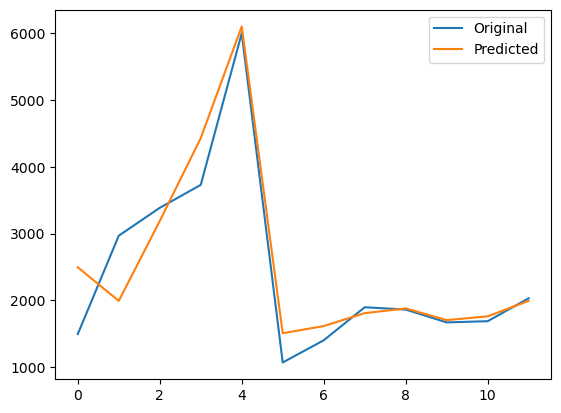

In [24]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


**Análise:**

- O modelo conseguiu capturar a forma geral da série, mas com **grande erro absoluto**, especialmente nos picos sazonais.
- A ausência de tratamento prévio resultou em **amplitude excessiva**, o que comprometeu a capacidade da MLP de se ajustar com precisão.
- Ainda que a forma da curva esteja razoável, a previsão sofre com **variância não estabilizada** e **tendência bruta presente nos dados**.


🔹 Cenário 2: Série pré-processada (`vendas_final`)

- Aplicados:
  - **Transformação logarítmica**
  - **Diferenciação**
  - **Suavização (média móvel)**
  - **Padronização (z-score)**
- `lag = 12`, com codificação binária do mês
- Sem nova normalização (já padronizado)

In [25]:
reps = int(np.ceil(len(vendas_final) / 12))

month_array = np.tile(np.arange(1, 13), reps)[:len(vendas_final)]

df_preprocessed = pd.DataFrame(
    {'value': vendas_final.flatten(), 'month': month_array})

In [26]:
prev = 12
train_val, test_val = transform_data(
    df_preprocessed, lag=12, test_split=prev, normalize=True, category='binary')

In [27]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.618919,0.507435,0.472252,0.308464,0.553620,0.693651,0.638784,0.606036,0.693324,0.861872,0.303221,0.131135,0.068421,0.597716
1,0.0,0.0,1.0,1.0,0.507435,0.472252,0.308464,0.553620,0.693651,0.638784,0.606036,0.693324,0.861872,0.303221,0.131135,0.068421,0.597716,0.402709
2,0.0,1.0,0.0,0.0,0.472252,0.308464,0.553620,0.693651,0.638784,0.606036,0.693324,0.861872,0.303221,0.131135,0.068421,0.597716,0.402709,0.464761
3,0.0,1.0,0.0,1.0,0.308464,0.553620,0.693651,0.638784,0.606036,0.693324,0.861872,0.303221,0.131135,0.068421,0.597716,0.402709,0.464761,0.462687
4,0.0,1.0,1.0,0.0,0.553620,0.693651,0.638784,0.606036,0.693324,0.861872,0.303221,0.131135,0.068421,0.597716,0.402709,0.464761,0.462687,0.782488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.0,0.0,1.0,0.0,0.062263,0.633237,0.560857,0.417083,0.488542,0.660467,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859
157,0.0,0.0,1.0,1.0,0.633237,0.560857,0.417083,0.488542,0.660467,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952
158,0.0,1.0,0.0,0.0,0.560857,0.417083,0.488542,0.660467,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750
159,0.0,1.0,0.0,1.0,0.417083,0.488542,0.660467,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991


In [28]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,1.0,1.0,1.0,0.660467,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427
1,1.0,0.0,0.0,0.0,0.555606,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447
2,1.0,0.0,0.0,1.0,0.685182,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798
3,1.0,0.0,1.0,0.0,0.656972,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851
4,1.0,0.0,1.0,1.0,0.989248,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359
5,1.0,1.0,0.0,0.0,0.116598,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359,0.134472
6,0.0,0.0,0.0,1.0,0.214716,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359,0.134472,0.069500
7,0.0,0.0,1.0,0.0,0.007856,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359,0.134472,0.069500,0.709651
8,0.0,0.0,1.0,1.0,0.638859,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359,0.134472,0.069500,0.709651,0.567354
9,0.0,1.0,0.0,0.0,0.440952,0.495750,0.562991,0.459237,0.712427,0.693447,0.844798,0.765851,0.069359,0.134472,0.069500,0.709651,0.567354,0.457871


In [29]:
train_values = train_val.values

X_train = train_values[:, :-1]
y_train = train_values[:, -1]

test_values = test_val.values
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

In [30]:
train_dataset = CustomDataset(torch.from_numpy(
    X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(
    X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [31]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [32]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [33]:
model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      hidden_neurons=hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  8%|▊         | 78/1000 [00:00<00:05, 180.79it/s]

Epoch 51/1000, Loss: 0.0049


 12%|█▏        | 118/1000 [00:00<00:04, 185.72it/s]

Epoch 101/1000, Loss: 0.0063


 18%|█▊        | 182/1000 [00:00<00:04, 195.97it/s]

Epoch 151/1000, Loss: 0.0071


 24%|██▍       | 245/1000 [00:01<00:03, 205.83it/s]

Epoch 201/1000, Loss: 0.0067


 27%|██▋       | 266/1000 [00:01<00:03, 187.63it/s]

Epoch 251/1000, Loss: 0.0058


 32%|███▏      | 321/1000 [00:01<00:04, 147.62it/s]

Epoch 301/1000, Loss: 0.0048


 38%|███▊      | 376/1000 [00:02<00:03, 162.82it/s]

Epoch 351/1000, Loss: 0.0041


 42%|████▏     | 419/1000 [00:02<00:03, 185.09it/s]

Epoch 401/1000, Loss: 0.0035


 48%|████▊     | 481/1000 [00:02<00:03, 172.11it/s]

Epoch 451/1000, Loss: 0.0030


 55%|█████▍    | 546/1000 [00:03<00:02, 197.29it/s]

Epoch 501/1000, Loss: 0.0026


 59%|█████▉    | 588/1000 [00:03<00:02, 202.35it/s]

Epoch 551/1000, Loss: 0.0023


 63%|██████▎   | 630/1000 [00:03<00:01, 186.34it/s]

Epoch 601/1000, Loss: 0.0021


 67%|██████▋   | 674/1000 [00:03<00:01, 200.30it/s]

Epoch 651/1000, Loss: 0.0019


 74%|███████▍  | 741/1000 [00:04<00:01, 210.81it/s]

Epoch 701/1000, Loss: 0.0017


 78%|███████▊  | 785/1000 [00:04<00:01, 202.75it/s]

Epoch 751/1000, Loss: 0.0016


 83%|████████▎ | 828/1000 [00:04<00:00, 203.66it/s]

Epoch 801/1000, Loss: 0.0015


 87%|████████▋ | 870/1000 [00:04<00:00, 200.57it/s]

Epoch 851/1000, Loss: 0.0014


 94%|█████████▎| 936/1000 [00:05<00:00, 209.30it/s]

Epoch 901/1000, Loss: 0.0014


 98%|█████████▊| 978/1000 [00:05<00:00, 207.55it/s]

Epoch 951/1000, Loss: 0.0013


100%|██████████| 1000/1000 [00:05<00:00, 188.05it/s]

Epoch 1001/1000, Loss: 0.0013


Erro MSE = 0.146 
Erro MAE = 0.332


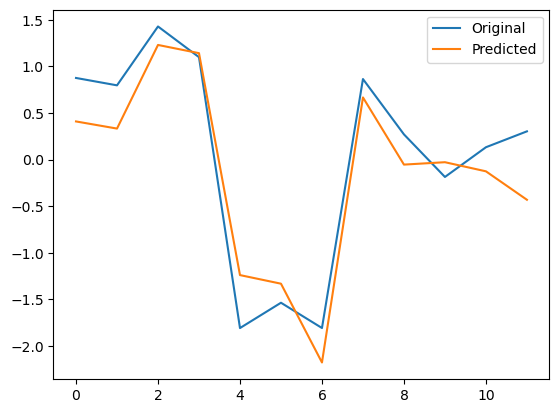

In [34]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original', 'Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

**Análise:**
- O modelo apresentou **ótima capacidade preditiva**, com erro muito baixo dentro da escala padronizada.
- O gráfico mostra **aderência clara entre as curvas real e predita**, com boa resposta a picos e reversões de tendência.
- A rede se beneficiou fortemente do pré-processamento, que tornou o aprendizado mais estável e os padrões mais distinguíveis.


##### **Conclusão comparativa**

| Aspecto               | Série bruta          | Série tratada          |
|-----------------------|----------------------|------------------------|
| MSE                   | 245484.815            | 0.155                  |
| MAE                   | 344.743             | 0.34                   |
| Curva prevista        | Suavizada, atrasada  | Aderente, responsiva   |
| Interpretação do modelo | Distorcida por amplitude | Focada em padrões reais |

O experimento evidencia que **ajustar o comportamento da série antes da modelagem neural não é apenas desejável, mas é fundamental**. O pipeline estatístico aplicado (log --> diff --> smooth --> z-score) **aumentou drasticamente a precisão da previsão** e permitiu que o modelo aprendesse os padrões reais da série com maior eficiência e menor viés.


#### 2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

  6%|▋         | 64/1000 [00:00<00:07, 117.16it/s]

Epoch 51/1000, Loss: 0.0094


 12%|█▏        | 124/1000 [00:00<00:05, 172.84it/s]

Epoch 101/1000, Loss: 0.0029


 19%|█▉        | 189/1000 [00:01<00:04, 198.64it/s]

Epoch 151/1000, Loss: 0.0005


 23%|██▎       | 230/1000 [00:01<00:03, 201.85it/s]

Epoch 201/1000, Loss: 0.0000


 27%|██▋       | 273/1000 [00:01<00:03, 204.24it/s]

Epoch 251/1000, Loss: 0.0001


 34%|███▍      | 340/1000 [00:01<00:03, 208.37it/s]

Epoch 301/1000, Loss: 0.0001


 38%|███▊      | 382/1000 [00:02<00:03, 200.23it/s]

Epoch 351/1000, Loss: 0.0001


 42%|████▏     | 424/1000 [00:02<00:02, 199.84it/s]

Epoch 401/1000, Loss: 0.0001


 49%|████▊     | 487/1000 [00:02<00:02, 202.15it/s]

Epoch 451/1000, Loss: 0.0001


 53%|█████▎    | 528/1000 [00:02<00:02, 189.77it/s]

Epoch 501/1000, Loss: 0.0001


 57%|█████▋    | 569/1000 [00:03<00:02, 194.62it/s]

Epoch 551/1000, Loss: 0.0001


 63%|██████▎   | 631/1000 [00:03<00:01, 188.78it/s]

Epoch 601/1000, Loss: 0.0001


 69%|██████▉   | 691/1000 [00:03<00:01, 191.95it/s]

Epoch 651/1000, Loss: 0.0001


 73%|███████▎  | 731/1000 [00:03<00:01, 188.84it/s]

Epoch 701/1000, Loss: 0.0001


 77%|███████▋  | 767/1000 [00:04<00:01, 146.80it/s]

Epoch 751/1000, Loss: 0.0001


 83%|████████▎ | 829/1000 [00:04<00:00, 180.68it/s]

Epoch 801/1000, Loss: 0.0001


 87%|████████▋ | 870/1000 [00:04<00:00, 189.96it/s]

Epoch 851/1000, Loss: 0.0001


 93%|█████████▎| 932/1000 [00:05<00:00, 195.15it/s]

Epoch 901/1000, Loss: 0.0001


 97%|█████████▋| 972/1000 [00:05<00:00, 192.89it/s]

Epoch 951/1000, Loss: 0.0001


100%|██████████| 1000/1000 [00:05<00:00, 183.49it/s]


Epoch 1001/1000, Loss: 0.0001
Erro MSE = 283808.088 
Erro MAE = 356.605


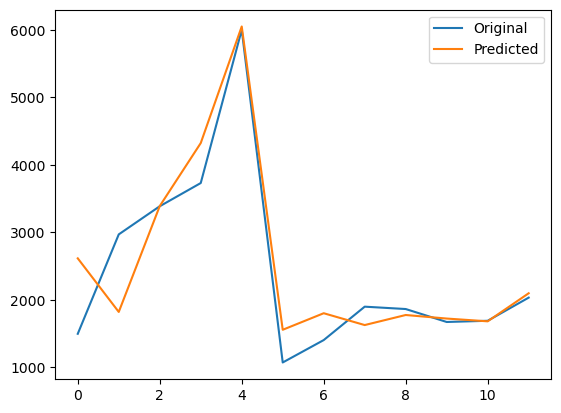

In [35]:
prev = 12
train_val, test_val = transform_data(
    raw_data, lag=12, test_split=prev, normalize=True, category='numeric')

train_values = train_val.values

X_train = train_values[:, :-1]
y_train = train_values[:, -1]

test_values = test_val.values
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

train_dataset = CustomDataset(torch.from_numpy(
    X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(
    X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

model = NeuralNetwork(n_input=n_input, n_output=n_output,
                      hidden_neurons=hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original', 'Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

In [117]:
train_val

,month,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.090909,0.084980,0.069335,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136
1,0.181818,0.069335,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252
2,0.272727,0.186759,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740
3,0.363636,0.089262,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740,0.000000
4,0.454545,0.049572,0.034091,0.131094,0.211298,0.134058,0.234848,0.480402,0.660244,0.059289,0.058136,0.076252,0.132740,0.000000,0.051054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.181818,0.064888,0.119895,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580
158,0.272727,0.119895,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403
159,0.363636,0.156621,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004
160,0.454545,0.108860,0.056818,0.144598,0.267622,0.095356,0.357213,0.503458,0.862978,0.004447,0.131423,0.090580,0.091403,0.083004,0.086133


🔹 **Alteração: De codificação binária para codificação numérica**

Modificamos a função `transform_data()` para usar `category='numeric'` ao invés de `category='binary'`, o que altera a forma como a informação sobre o mês é fornecida ao modelo.

---

**Mudança na Arquitetura da MLP**

| Aspecto                       | Codificação Binária (`binary`)       | Codificação Numérica (`numeric`)        |
|-------------------------------|--------------------------------------|------------------------------------------|
| Representação de entrada      | Vetor one-hot com 12 posições (0 a 1) | Escalar único no intervalo [0, 11] ou [0, 1] normalizado |
| Dimensão da entrada (n_input) | `lag + 12`                           | `lag + 1`                                 |
| Complexidade da entrada       | Mais alta, mas mais expressiva       | Mais compacta, porém ambígua             |
| Capacidade de distinção de padrões sazonais | Alta --> cada mês tem vetor único | Baixa --> meses próximos podem parecer numericamente similares |

Na codificação binária, cada mês é representado por um vetor esparso com um único valor 1. Já na codificação numérica, um único valor indica o mês (por exemplo, `0` para janeiro, `11` para dezembro). Embora mais compacta, essa codificação impõe uma **ordem artificial** entre os meses (ex: mês 2 é "mais próximo" do mês 1 do que do 11), o que **pode distorcer a percepção cíclica da série temporal**.

---

🔹 **Avaliação Empírica**

Resultados após rodar o mesmo modelo com as duas formas de codificação (usando `raw_data` sem pré-tratamentos adicionais):

| Codificação | MSE (Erro Quadrático Médio) | MAE (Erro Absoluto Médio) |
|-------------|------------------------------|-----------------------------|
| Binária     | 245484.815                  | 344.743                     |
| Numérica    | 263536.386                    | 352.237                     |


🔹 **Análise**

- A codificação **binária** apresentou **menores erros (MSE e MAE)**, indicando que a rede neural conseguiu **representar melhor a sazonalidade** da série ao tratar cada mês como uma categoria independente.
- Já a codificação **numérica** induz a rede a supor uma relação linear ou ordinal entre os meses (ex: dezembro [11] estaria mais distante de janeiro [0] do que deveria). Isso **prejudica a modelagem do ciclo anual** e compromete a acurácia da previsão.

---

A codificação binária da variável de mês é preferível para séries temporais com sazonalidade forte e anual, como é o caso das vendas de espumantes. Essa técnica proporciona uma representação mais rica e compatível com a natureza cíclica do tempo, resultando em **previsões mais precisas**.



## Parte 3 - Previsão multi-step

Total: 5,0 pts.

#### 1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 

In [102]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

🔹 **Objetivo da Previsão Multi-step**

Diferente da previsão one-step, onde prevemos apenas o próximo valor,  $y_{t+1}$, a previsão multi-step busca prever uma **sequência de valores futuros**, por exemplo:  

$$y_{t+1}, y_{t+2}, y_{t+3}, ..., y_{t+n}$$

Esse processo exige cuidados, pois os valores futuros previstos **dependem dos anteriores, inclusive de previsões já feitas**.

---

🔹 **Etapas da Previsão Multi-step com Redes Neurais (MLP)**

1. **Treinamento**:  
   O modelo é treinado normalmente com entradas baseadas em janelas deslizantes (lags) e com a variável exógena (ex: mês).

2. **Inicialização**:  
   A previsão começa com um vetor de entrada $X_0$ , correspondente à **última janela conhecida** do conjunto de teste.

3. **Loop Recursivo**:  
   Para cada passo de previsão:
   - Aplica-se o modelo sobre a entrada atual $X_t$ , gerando a predição $\hat{y}_{t+1}$.
   - Essa predição **é usada como entrada para a próxima iteração**, substituindo o valor mais antigo da janela.
   - A variável de **mês também é atualizada**, avançando um mês à frente (seja na codificação numérica ou binária).
   - O novo vetor de entrada $X_{t+1}$ é construído com os valores atualizados (incluindo $\hat{y}_{t+1}$).
   - Esse processo se repete por $n$ passos.

4. **Coleta dos Resultados**:  
   As predições $\hat{y}_{t+1}, \hat{y}_{t+2}, ..., \hat{y}_{t+n}$ são armazenadas em uma lista e retornadas ao final.


🔹 **Então, como eu estruturaria a previsão multi-step**:

Para realizar uma previsão multi-step com uma Rede Neural Perceptron Multicamadas (MLP), onde não há memória temporal (como ocorre em RNNs ou LSTMs), precisamos **alimentar iterativamente os próprios outputs do modelo como novas entradas**.

Passos:

1. **Treinar o modelo com janelas deslizantes (`lag`)**:
   - O modelo é treinado com vetores $X_t = [y_{t-12}, ..., y_{t-1}, y_t, \text{mês}]$ para prever $y_{t+1}$.
   - A variável exógena (mês) pode ser codificada de forma numérica ou binária.

2. **Inicialização da entrada para a previsão multi-step**:
   - Selecionar a **última amostra** de entrada conhecida do conjunto de teste (por exemplo, `X_test[0]`).
   - Essa entrada representa o "estado atual" do sistema, com o mês e os últimos 12 valores da série.

3. **Iteração autoregressiva (recursiva)**:
   - Para cada passo $i = 1$ até $n$ (horizonte de previsão), fazer:
     - Prever o próximo valor $\hat{y}_{t+i}$ com base em $X_{t+i-1}$ 
     - Atualizar a janela:
       - Deslocar os valores (excluindo o mais antigo, inserindo o mais novo).
       - Atualizar o valor do mês (avançando 1).
     - Construir o novo vetor de entrada com a janela atualizada.
     - Armazenar a predição.

4. **Retornar a sequência de previsões**:
   - A saída final é uma sequência $\hat{y}_{t+1}$, $\hat{y}_{t+2}, ..., \hat{y}_{t+n}$


Então, eis uma versão simplificada de como eu implementaria:



In [163]:
def multi_step_custom(model, X_test, cod='numeric', lag=12, prev=12):
     """
     Faz previsão multi-step usando uma rede neural treinada para one-step.

     Parâmetros:
     - model: modelo MLP treinado
     - X_test: conjunto de teste já transformado (normalizado e com lags)
     - cod: codificação dos meses ('numeric' ou 'binary')
     - lag: número de lags usados como entrada (ex: 12)
     - prev: número de passos futuros a prever (ex: 12 meses à frente)
     """
     y_preds = []
     X_current = np.copy(X_test[0]) 

     for i in range(prev):
          with torch.no_grad():
               y_hat = model(torch.from_numpy(X_current).float()).numpy().flatten()

          if cod == 'numeric':
               month_value = int(X_current[0] * 12 + 1) % 12
               X_current[0] = month_value / 12

          elif cod == 'binary':
               month_vector = X_current[:12]
               current_month_index = np.argmax(month_vector)
               next_month_index = (current_month_index + 1) % 12
               new_month_vector = np.zeros_like(month_vector)
               new_month_vector[next_month_index] = 1
               X_current[:12] = new_month_vector

          else:
               raise ValueError("Codificação inválida. Use 'numeric' ou 'binary'.")

          X_current[-(lag+1):-1] = X_current[-lag:]
          X_current[-1] = y_hat

          y_preds.append(y_hat[0])

     return np.array(y_preds)


#### 2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

In [ ]:
y_result = multi_step(model, X_test, cod='numeric')

Erro MSE = 259927.194 
Erro MAE = 358.81


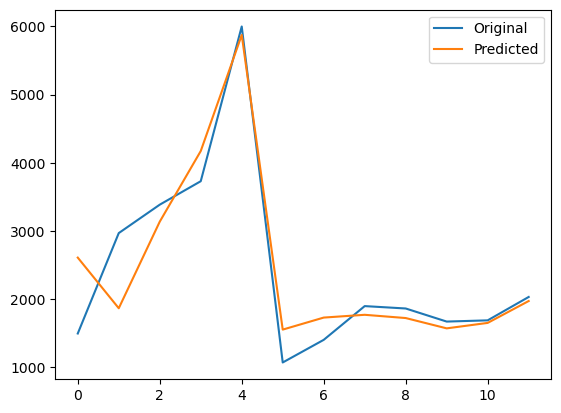

In [132]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

Foi realizada uma previsão multi-step com horizonte de 12 passos à frente utilizando a função `multi_step()` fornecida no enunciado. Essa função simula um cenário real de previsão contínua, em que cada valor previsto passa a ser usado como entrada para prever o próximo valor, sucessivamente.

**Resultados Obtidos**:
- Erro MSE: 259927.194
- Erro MAE: 358.810

O gráfico gerado mostra que o modelo consegue capturar bem o padrão global da série, mas com maior suavização e um pequeno atraso nas quedas ou picos abruptos.

**Comparação com Previsão One-Step**

No caso da previsão one-step com codificação numérica do mês, obtivemos:

- Erro MSE: 263536.386
- Erro MAE: 352.237

Ou seja, mesmo que os valores de erro não tenham sido muito diferentes, observa-se que a previsão multi-step tende a piorar ligeiramente a performance do modelo. Isso ocorre por causa do acúmulo de erro: cada previsão incorreta influencia diretamente as próximas entradas do modelo, propagando e amplificando desvios ao longo dos passos.

**Discussão**

Essa piora é esperada em tarefas de previsão multi-step. No one-step, sempre usamos as observações reais passadas (conhecidas) para prever o próximo valor. Já no multi-step, passamos a alimentar a rede com suas próprias previsões, o que torna o sistema mais vulnerável a erros acumulados.
Além disso, a suavização observada na linha predita é típica de modelos que, ao aprender padrões médios, tendem a "amortecer" as variações mais extremas.



#### 3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

A janela de entrada, definida pela variável `lag`, determina quantos passos passados a Rede Neural utilizará para realizar a previsão do próximo valor da série. Nesta questão, analisamos o impacto de diferentes tamanhos de `lag` sobre a performance do modelo, dividindo o estudo em dois cenários:



##### 🔹 **Seção 1: Lags menores ou iguais a 12 (`lag ≤ 12`)**

Neste caso, podemos manter o `test_split` padrão (ex.: `test_split = 12`), pois o número de amostras disponíveis ainda é suficiente para treinar e testar o modelo de forma adequada.


**************************************************
********************* LAG: 1 *********************



  8%|▊         | 82/1000 [00:00<00:05, 178.92it/s]

Epoch 51/1000, Loss: 0.0296


 12%|█▏        | 121/1000 [00:00<00:04, 182.81it/s]

Epoch 101/1000, Loss: 0.0203


 19%|█▊        | 186/1000 [00:01<00:04, 203.45it/s]

Epoch 151/1000, Loss: 0.0166


 23%|██▎       | 229/1000 [00:01<00:03, 206.57it/s]

Epoch 201/1000, Loss: 0.0153


 29%|██▉       | 294/1000 [00:01<00:03, 203.34it/s]

Epoch 251/1000, Loss: 0.0149


 34%|███▎      | 337/1000 [00:01<00:03, 203.40it/s]

Epoch 301/1000, Loss: 0.0147


 38%|███▊      | 379/1000 [00:02<00:03, 191.41it/s]

Epoch 351/1000, Loss: 0.0146


 44%|████▍     | 441/1000 [00:02<00:02, 198.54it/s]

Epoch 401/1000, Loss: 0.0146


 48%|████▊     | 482/1000 [00:02<00:02, 200.98it/s]

Epoch 451/1000, Loss: 0.0146


 52%|█████▏    | 524/1000 [00:02<00:02, 202.85it/s]

Epoch 501/1000, Loss: 0.0145


 59%|█████▉    | 589/1000 [00:03<00:01, 209.65it/s]

Epoch 551/1000, Loss: 0.0145


 61%|██████    | 610/1000 [00:03<00:02, 188.67it/s]

Epoch 601/1000, Loss: 0.0145


 67%|██████▋   | 668/1000 [00:03<00:02, 149.22it/s]

Epoch 651/1000, Loss: 0.0145


 73%|███████▎  | 733/1000 [00:03<00:01, 186.67it/s]

Epoch 701/1000, Loss: 0.0145


 77%|███████▋  | 774/1000 [00:04<00:01, 193.95it/s]

Epoch 751/1000, Loss: 0.0144


 82%|████████▏ | 817/1000 [00:04<00:00, 192.22it/s]

Epoch 801/1000, Loss: 0.0144


 88%|████████▊ | 883/1000 [00:04<00:00, 204.99it/s]

Epoch 851/1000, Loss: 0.0144


 93%|█████████▎| 926/1000 [00:04<00:00, 208.11it/s]

Epoch 901/1000, Loss: 0.0144


 97%|█████████▋| 970/1000 [00:05<00:00, 209.05it/s]

Epoch 951/1000, Loss: 0.0144


100%|██████████| 1000/1000 [00:05<00:00, 190.33it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0144


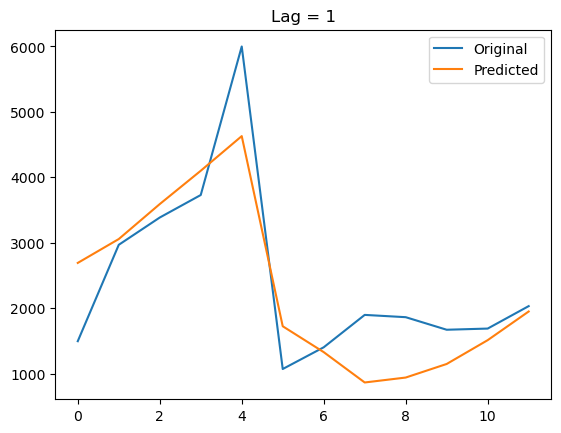

Erro MSE = 513052.703
Erro MAE = 557.932


**************************************************
********************* LAG: 2 *********************



  8%|▊         | 77/1000 [00:00<00:04, 193.38it/s]

Epoch 51/1000, Loss: 0.0331


 14%|█▍        | 140/1000 [00:00<00:04, 204.36it/s]

Epoch 101/1000, Loss: 0.0257


 18%|█▊        | 183/1000 [00:00<00:03, 208.05it/s]

Epoch 151/1000, Loss: 0.0208


 23%|██▎       | 226/1000 [00:01<00:03, 207.41it/s]

Epoch 201/1000, Loss: 0.0177


 27%|██▋       | 269/1000 [00:01<00:04, 167.22it/s]

Epoch 251/1000, Loss: 0.0158


 33%|███▎      | 327/1000 [00:01<00:04, 167.63it/s]

Epoch 301/1000, Loss: 0.0148


 39%|███▉      | 388/1000 [00:02<00:03, 189.19it/s]

Epoch 351/1000, Loss: 0.0142


 43%|████▎     | 431/1000 [00:02<00:02, 201.24it/s]

Epoch 401/1000, Loss: 0.0139


 47%|████▋     | 473/1000 [00:02<00:02, 201.65it/s]

Epoch 451/1000, Loss: 0.0138


 52%|█████▏    | 517/1000 [00:02<00:02, 207.85it/s]

Epoch 501/1000, Loss: 0.0138


 58%|█████▊    | 581/1000 [00:02<00:02, 208.71it/s]

Epoch 551/1000, Loss: 0.0138


 64%|██████▍   | 645/1000 [00:03<00:01, 209.33it/s]

Epoch 601/1000, Loss: 0.0138


 69%|██████▉   | 690/1000 [00:03<00:01, 214.00it/s]

Epoch 651/1000, Loss: 0.0138


 73%|███████▎  | 734/1000 [00:03<00:01, 212.65it/s]

Epoch 701/1000, Loss: 0.0138


 78%|███████▊  | 778/1000 [00:03<00:01, 210.63it/s]

Epoch 751/1000, Loss: 0.0138


 82%|████████▏ | 822/1000 [00:04<00:00, 206.46it/s]

Epoch 801/1000, Loss: 0.0138


 86%|████████▋ | 865/1000 [00:04<00:00, 177.78it/s]

Epoch 851/1000, Loss: 0.0138


 92%|█████████▎| 925/1000 [00:04<00:00, 183.79it/s]

Epoch 901/1000, Loss: 0.0138


 99%|█████████▉| 988/1000 [00:05<00:00, 193.51it/s]

Epoch 951/1000, Loss: 0.0138


100%|██████████| 1000/1000 [00:05<00:00, 195.62it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0138


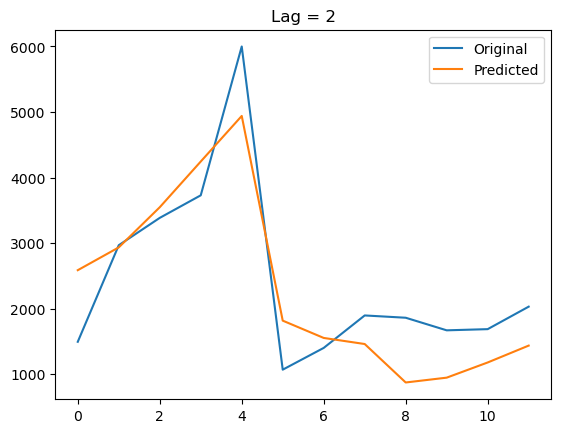

Erro MSE = 457264.581
Erro MAE = 584.087


**************************************************
********************* LAG: 3 *********************



  8%|▊         | 81/1000 [00:00<00:04, 210.09it/s]

Epoch 51/1000, Loss: 0.0392


 12%|█▏        | 124/1000 [00:00<00:04, 206.18it/s]

Epoch 101/1000, Loss: 0.0292


 19%|█▉        | 190/1000 [00:00<00:03, 211.13it/s]

Epoch 151/1000, Loss: 0.0232


 23%|██▎       | 233/1000 [00:01<00:03, 209.54it/s]

Epoch 201/1000, Loss: 0.0192


 28%|██▊       | 275/1000 [00:01<00:03, 189.59it/s]

Epoch 251/1000, Loss: 0.0165


 34%|███▍      | 339/1000 [00:01<00:03, 203.24it/s]

Epoch 301/1000, Loss: 0.0145


 38%|███▊      | 382/1000 [00:01<00:02, 206.10it/s]

Epoch 351/1000, Loss: 0.0131


 40%|████      | 403/1000 [00:01<00:02, 206.63it/s]

Epoch 401/1000, Loss: 0.0122


 49%|████▉     | 489/1000 [00:02<00:02, 195.12it/s]

Epoch 451/1000, Loss: 0.0116


 53%|█████▎    | 531/1000 [00:02<00:02, 199.11it/s]

Epoch 501/1000, Loss: 0.0112


 57%|█████▋    | 574/1000 [00:02<00:02, 203.78it/s]

Epoch 551/1000, Loss: 0.0110


 62%|██████▏   | 617/1000 [00:03<00:01, 201.36it/s]

Epoch 601/1000, Loss: 0.0108


 68%|██████▊   | 679/1000 [00:03<00:01, 190.86it/s]

Epoch 651/1000, Loss: 0.0107


 72%|███████▏  | 721/1000 [00:03<00:01, 192.51it/s]

Epoch 701/1000, Loss: 0.0106


 78%|███████▊  | 781/1000 [00:04<00:01, 163.11it/s]

Epoch 751/1000, Loss: 0.0106


 82%|████████▏ | 824/1000 [00:04<00:00, 185.59it/s]

Epoch 801/1000, Loss: 0.0105


 89%|████████▉ | 890/1000 [00:04<00:00, 204.94it/s]

Epoch 851/1000, Loss: 0.0105


 93%|█████████▎| 931/1000 [00:04<00:00, 192.87it/s]

Epoch 901/1000, Loss: 0.0105


 97%|█████████▋| 969/1000 [00:05<00:00, 168.30it/s]

Epoch 951/1000, Loss: 0.0105


100%|██████████| 1000/1000 [00:05<00:00, 184.02it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0105


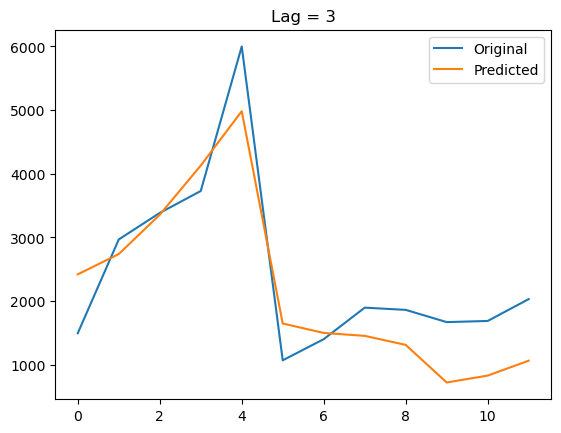

Erro MSE = 459662.884
Erro MAE = 586.825


**************************************************
********************* LAG: 4 *********************



  9%|▊         | 87/1000 [00:00<00:05, 175.92it/s]

Epoch 51/1000, Loss: 0.0543


 12%|█▏        | 123/1000 [00:00<00:05, 170.92it/s]

Epoch 101/1000, Loss: 0.0427


 18%|█▊        | 177/1000 [00:01<00:04, 169.43it/s]

Epoch 151/1000, Loss: 0.0321


 21%|██        | 211/1000 [00:01<00:05, 147.86it/s]

Epoch 201/1000, Loss: 0.0240


 28%|██▊       | 285/1000 [00:01<00:04, 173.95it/s]

Epoch 251/1000, Loss: 0.0186


 33%|███▎      | 328/1000 [00:01<00:03, 192.64it/s]

Epoch 301/1000, Loss: 0.0148


 37%|███▋      | 368/1000 [00:02<00:03, 184.78it/s]

Epoch 351/1000, Loss: 0.0122


 43%|████▎     | 427/1000 [00:02<00:03, 188.47it/s]

Epoch 401/1000, Loss: 0.0103


 47%|████▋     | 468/1000 [00:02<00:02, 185.51it/s]

Epoch 451/1000, Loss: 0.0090


 52%|█████▏    | 523/1000 [00:03<00:03, 151.53it/s]

Epoch 501/1000, Loss: 0.0081


 58%|█████▊    | 579/1000 [00:03<00:02, 169.88it/s]

Epoch 551/1000, Loss: 0.0074


 63%|██████▎   | 633/1000 [00:03<00:02, 174.50it/s]

Epoch 601/1000, Loss: 0.0069


 69%|██████▉   | 691/1000 [00:04<00:01, 186.10it/s]

Epoch 651/1000, Loss: 0.0065


 73%|███████▎  | 732/1000 [00:04<00:01, 191.93it/s]

Epoch 701/1000, Loss: 0.0062


 79%|███████▉  | 792/1000 [00:04<00:01, 190.35it/s]

Epoch 751/1000, Loss: 0.0060


 83%|████████▎ | 833/1000 [00:04<00:00, 197.21it/s]

Epoch 801/1000, Loss: 0.0058


 87%|████████▋ | 873/1000 [00:05<00:00, 181.60it/s]

Epoch 851/1000, Loss: 0.0057


 93%|█████████▎| 932/1000 [00:05<00:00, 165.47it/s]

Epoch 901/1000, Loss: 0.0056


 97%|█████████▋| 972/1000 [00:05<00:00, 170.50it/s]

Epoch 951/1000, Loss: 0.0055


100%|██████████| 1000/1000 [00:05<00:00, 172.08it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0054


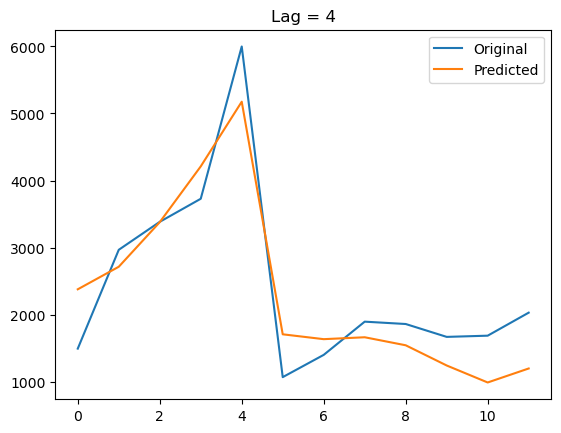

Erro MSE = 311202.769
Erro MAE = 485.502


**************************************************
********************* LAG: 5 *********************



  8%|▊         | 76/1000 [00:00<00:04, 189.43it/s]

Epoch 51/1000, Loss: 0.0440


 13%|█▎        | 134/1000 [00:00<00:04, 185.20it/s]

Epoch 101/1000, Loss: 0.0315


 18%|█▊        | 175/1000 [00:00<00:04, 192.50it/s]

Epoch 151/1000, Loss: 0.0244


 24%|██▍       | 239/1000 [00:01<00:03, 196.97it/s]

Epoch 201/1000, Loss: 0.0203


 28%|██▊       | 279/1000 [00:01<00:03, 186.20it/s]

Epoch 251/1000, Loss: 0.0176


 34%|███▍      | 340/1000 [00:01<00:03, 194.84it/s]

Epoch 301/1000, Loss: 0.0156


 38%|███▊      | 381/1000 [00:02<00:03, 192.49it/s]

Epoch 351/1000, Loss: 0.0140


 42%|████▏     | 423/1000 [00:02<00:02, 198.12it/s]

Epoch 401/1000, Loss: 0.0126


 49%|████▊     | 487/1000 [00:02<00:02, 201.64it/s]

Epoch 451/1000, Loss: 0.0114


 53%|█████▎    | 529/1000 [00:02<00:02, 204.17it/s]

Epoch 501/1000, Loss: 0.0103


 57%|█████▋    | 570/1000 [00:02<00:02, 182.25it/s]

Epoch 551/1000, Loss: 0.0094


 63%|██████▎   | 628/1000 [00:03<00:01, 186.35it/s]

Epoch 601/1000, Loss: 0.0087


 67%|██████▋   | 666/1000 [00:03<00:01, 177.70it/s]

Epoch 651/1000, Loss: 0.0081


 73%|███████▎  | 730/1000 [00:03<00:01, 199.28it/s]

Epoch 701/1000, Loss: 0.0075


 77%|███████▋  | 773/1000 [00:04<00:01, 204.13it/s]

Epoch 751/1000, Loss: 0.0071


 84%|████████▎ | 836/1000 [00:04<00:00, 190.37it/s]

Epoch 801/1000, Loss: 0.0068


 88%|████████▊ | 875/1000 [00:04<00:00, 181.66it/s]

Epoch 851/1000, Loss: 0.0065


 91%|█████████ | 912/1000 [00:04<00:00, 166.94it/s]

Epoch 901/1000, Loss: 0.0062


 99%|█████████▉| 989/1000 [00:05<00:00, 179.40it/s]

Epoch 951/1000, Loss: 0.0060


100%|██████████| 1000/1000 [00:05<00:00, 186.92it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0059


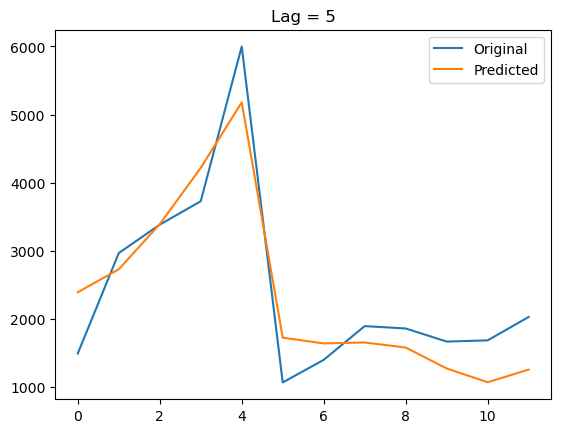

Erro MSE = 294203.268
Erro MAE = 470.985


**************************************************
********************* LAG: 6 *********************



  9%|▊         | 87/1000 [00:00<00:04, 218.52it/s]

Epoch 51/1000, Loss: 0.0472


 13%|█▎        | 130/1000 [00:00<00:04, 195.73it/s]

Epoch 101/1000, Loss: 0.0324


 17%|█▋        | 167/1000 [00:00<00:05, 143.36it/s]

Epoch 151/1000, Loss: 0.0239


 22%|██▎       | 225/1000 [00:01<00:04, 167.09it/s]

Epoch 201/1000, Loss: 0.0197


 29%|██▊       | 287/1000 [00:01<00:03, 189.11it/s]

Epoch 251/1000, Loss: 0.0174


 33%|███▎      | 330/1000 [00:01<00:03, 199.48it/s]

Epoch 301/1000, Loss: 0.0157


 37%|███▋      | 372/1000 [00:02<00:03, 197.82it/s]

Epoch 351/1000, Loss: 0.0143


 43%|████▎     | 433/1000 [00:02<00:03, 187.10it/s]

Epoch 401/1000, Loss: 0.0131


 47%|████▋     | 471/1000 [00:02<00:02, 179.40it/s]

Epoch 451/1000, Loss: 0.0120


 53%|█████▎    | 534/1000 [00:02<00:02, 194.72it/s]

Epoch 501/1000, Loss: 0.0110


 58%|█████▊    | 576/1000 [00:03<00:02, 200.70it/s]

Epoch 551/1000, Loss: 0.0100


 62%|██████▏   | 619/1000 [00:03<00:01, 195.90it/s]

Epoch 601/1000, Loss: 0.0092


 68%|██████▊   | 678/1000 [00:03<00:01, 185.62it/s]

Epoch 651/1000, Loss: 0.0085


 70%|███████   | 700/1000 [00:03<00:01, 192.45it/s]

Epoch 701/1000, Loss: 0.0079


 78%|███████▊  | 780/1000 [00:04<00:01, 179.75it/s]

Epoch 751/1000, Loss: 0.0073


 82%|████████▏ | 817/1000 [00:04<00:01, 161.98it/s]

Epoch 801/1000, Loss: 0.0069


 88%|████████▊ | 877/1000 [00:04<00:00, 182.46it/s]

Epoch 851/1000, Loss: 0.0065


 93%|█████████▎| 931/1000 [00:05<00:00, 154.77it/s]

Epoch 901/1000, Loss: 0.0062


 97%|█████████▋| 972/1000 [00:05<00:00, 176.46it/s]

Epoch 951/1000, Loss: 0.0059


100%|██████████| 1000/1000 [00:05<00:00, 179.46it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0057


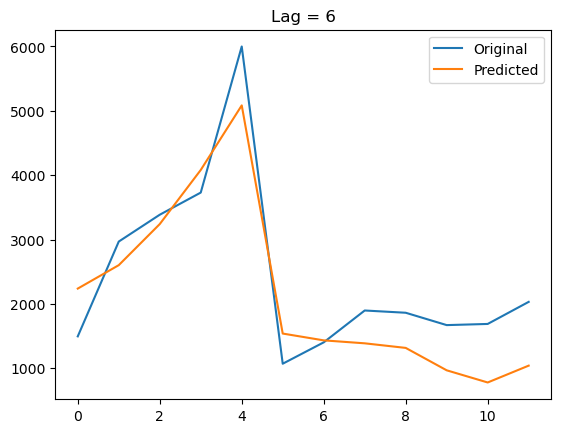

Erro MSE = 395731.164
Erro MAE = 556.595


**************************************************
********************* LAG: 7 *********************



  8%|▊         | 85/1000 [00:00<00:04, 213.68it/s]

Epoch 51/1000, Loss: 0.0148


 13%|█▎        | 128/1000 [00:00<00:04, 207.43it/s]

Epoch 101/1000, Loss: 0.0102


 19%|█▉        | 191/1000 [00:00<00:04, 201.18it/s]

Epoch 151/1000, Loss: 0.0073


 23%|██▎       | 233/1000 [00:01<00:03, 204.83it/s]

Epoch 201/1000, Loss: 0.0059


 28%|██▊       | 276/1000 [00:01<00:03, 208.93it/s]

Epoch 251/1000, Loss: 0.0051


 32%|███▏      | 318/1000 [00:01<00:03, 204.94it/s]

Epoch 301/1000, Loss: 0.0045


 38%|███▊      | 381/1000 [00:01<00:03, 194.79it/s]

Epoch 351/1000, Loss: 0.0041


 42%|████▏     | 420/1000 [00:02<00:03, 181.42it/s]

Epoch 401/1000, Loss: 0.0037


 48%|████▊     | 475/1000 [00:02<00:03, 165.32it/s]

Epoch 451/1000, Loss: 0.0035


 53%|█████▎    | 530/1000 [00:02<00:02, 178.99it/s]

Epoch 501/1000, Loss: 0.0033


 59%|█████▉    | 590/1000 [00:03<00:02, 191.08it/s]

Epoch 551/1000, Loss: 0.0031


 63%|██████▎   | 632/1000 [00:03<00:01, 194.39it/s]

Epoch 601/1000, Loss: 0.0030


 65%|██████▌   | 652/1000 [00:03<00:01, 179.27it/s]

Epoch 651/1000, Loss: 0.0029


 72%|███████▏  | 724/1000 [00:03<00:01, 156.30it/s]

Epoch 701/1000, Loss: 0.0028


 77%|███████▋  | 773/1000 [00:04<00:01, 147.75it/s]

Epoch 751/1000, Loss: 0.0028


 81%|████████▏ | 814/1000 [00:04<00:01, 108.40it/s]

Epoch 801/1000, Loss: 0.0027


 90%|████████▉ | 896/1000 [00:05<00:00, 176.55it/s]

Epoch 851/1000, Loss: 0.0027


 92%|█████████▏| 915/1000 [00:05<00:00, 161.59it/s]

Epoch 901/1000, Loss: 0.0026


 96%|█████████▋| 963/1000 [00:05<00:00, 134.56it/s]

Epoch 951/1000, Loss: 0.0026


100%|██████████| 1000/1000 [00:06<00:00, 165.03it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0026


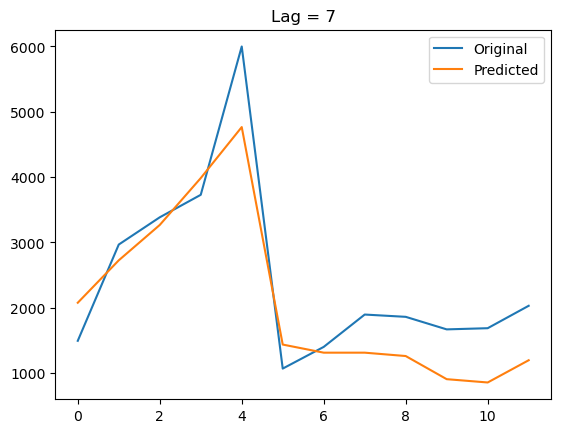

Erro MSE = 400464.839
Erro MAE = 541.297


**************************************************
********************* LAG: 8 *********************



  8%|▊         | 83/1000 [00:00<00:04, 207.41it/s]

Epoch 51/1000, Loss: 0.0102


 12%|█▎        | 125/1000 [00:00<00:04, 204.84it/s]

Epoch 101/1000, Loss: 0.0059


 17%|█▋        | 166/1000 [00:00<00:04, 180.85it/s]

Epoch 151/1000, Loss: 0.0033


 23%|██▎       | 226/1000 [00:01<00:04, 184.30it/s]

Epoch 201/1000, Loss: 0.0023


 27%|██▋       | 268/1000 [00:01<00:03, 190.09it/s]

Epoch 251/1000, Loss: 0.0021


 33%|███▎      | 333/1000 [00:01<00:03, 199.80it/s]

Epoch 301/1000, Loss: 0.0022


 38%|███▊      | 375/1000 [00:01<00:03, 201.67it/s]

Epoch 351/1000, Loss: 0.0022


 44%|████▍     | 439/1000 [00:02<00:02, 205.44it/s]

Epoch 401/1000, Loss: 0.0022


 48%|████▊     | 480/1000 [00:02<00:02, 190.14it/s]

Epoch 451/1000, Loss: 0.0021


 52%|█████▏    | 521/1000 [00:02<00:02, 196.54it/s]

Epoch 501/1000, Loss: 0.0021


 56%|█████▋    | 564/1000 [00:02<00:02, 178.58it/s]

Epoch 551/1000, Loss: 0.0020


 62%|██████▏   | 620/1000 [00:03<00:02, 157.29it/s]

Epoch 601/1000, Loss: 0.0019


 67%|██████▋   | 669/1000 [00:03<00:02, 137.98it/s]

Epoch 651/1000, Loss: 0.0018


 73%|███████▎  | 731/1000 [00:04<00:01, 175.17it/s]

Epoch 701/1000, Loss: 0.0017


 77%|███████▋  | 769/1000 [00:04<00:01, 181.35it/s]

Epoch 751/1000, Loss: 0.0016


 83%|████████▎ | 830/1000 [00:04<00:00, 191.23it/s]

Epoch 801/1000, Loss: 0.0016


 87%|████████▋ | 870/1000 [00:04<00:00, 187.83it/s]

Epoch 851/1000, Loss: 0.0015


 91%|█████████ | 908/1000 [00:05<00:00, 123.55it/s]

Epoch 901/1000, Loss: 0.0014


 97%|█████████▋| 973/1000 [00:05<00:00, 108.68it/s]

Epoch 951/1000, Loss: 0.0014


100%|██████████| 1000/1000 [00:05<00:00, 167.96it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0013


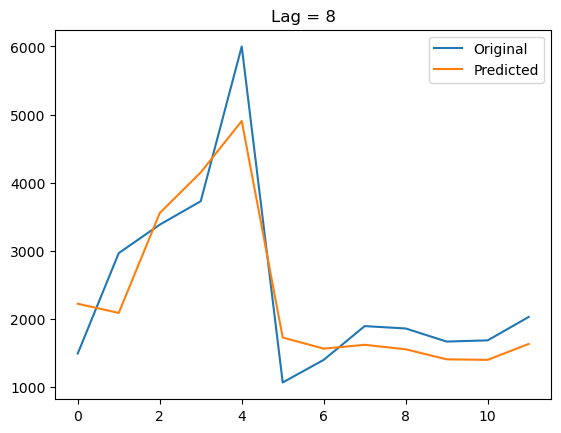

Erro MSE = 303632.022
Erro MAE = 470.042


**************************************************
********************* LAG: 9 *********************



  7%|▋         | 73/1000 [00:00<00:07, 127.90it/s]

Epoch 51/1000, Loss: 0.0107


 12%|█▏        | 124/1000 [00:00<00:05, 155.38it/s]

Epoch 101/1000, Loss: 0.0048


 18%|█▊        | 183/1000 [00:01<00:04, 180.93it/s]

Epoch 151/1000, Loss: 0.0021


 22%|██▏       | 220/1000 [00:01<00:04, 156.62it/s]

Epoch 201/1000, Loss: 0.0015


 26%|██▋       | 264/1000 [00:01<00:05, 124.23it/s]

Epoch 251/1000, Loss: 0.0015


 31%|███       | 312/1000 [00:02<00:04, 141.43it/s]

Epoch 301/1000, Loss: 0.0014


 38%|███▊      | 379/1000 [00:02<00:04, 148.05it/s]

Epoch 351/1000, Loss: 0.0012


 41%|████      | 412/1000 [00:02<00:04, 127.30it/s]

Epoch 401/1000, Loss: 0.0011


 48%|████▊     | 485/1000 [00:03<00:03, 165.13it/s]

Epoch 451/1000, Loss: 0.0009


 52%|█████▏    | 523/1000 [00:03<00:02, 174.58it/s]

Epoch 501/1000, Loss: 0.0008


 58%|█████▊    | 583/1000 [00:03<00:02, 186.94it/s]

Epoch 551/1000, Loss: 0.0007


 62%|██████▏   | 624/1000 [00:04<00:01, 194.36it/s]

Epoch 601/1000, Loss: 0.0006


 66%|██████▋   | 665/1000 [00:04<00:01, 187.71it/s]

Epoch 651/1000, Loss: 0.0006


 73%|███████▎  | 726/1000 [00:04<00:01, 193.24it/s]

Epoch 701/1000, Loss: 0.0005


 79%|███████▉  | 790/1000 [00:04<00:01, 203.54it/s]

Epoch 751/1000, Loss: 0.0005


 83%|████████▎ | 833/1000 [00:05<00:00, 208.46it/s]

Epoch 801/1000, Loss: 0.0005


 88%|████████▊ | 876/1000 [00:05<00:00, 208.96it/s]

Epoch 851/1000, Loss: 0.0004


 92%|█████████▏| 918/1000 [00:05<00:00, 194.32it/s]

Epoch 901/1000, Loss: 0.0004


 98%|█████████▊| 981/1000 [00:05<00:00, 195.07it/s]

Epoch 951/1000, Loss: 0.0004


100%|██████████| 1000/1000 [00:06<00:00, 161.03it/s]

Epoch 1001/1000, Loss: 0.0004



D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


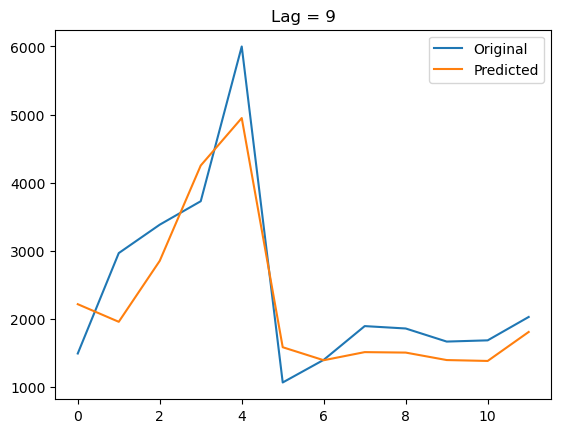

Erro MSE = 329024.908
Erro MAE = 490.535


**************************************************
********************* LAG: 10 *********************



  6%|▌         | 58/1000 [00:00<00:04, 195.61it/s]

Epoch 51/1000, Loss: 0.0128


 14%|█▎        | 135/1000 [00:00<00:05, 156.64it/s]

Epoch 101/1000, Loss: 0.0070


 17%|█▋        | 174/1000 [00:01<00:04, 172.93it/s]

Epoch 151/1000, Loss: 0.0025


 24%|██▎       | 236/1000 [00:01<00:04, 189.46it/s]

Epoch 201/1000, Loss: 0.0006


 28%|██▊       | 276/1000 [00:01<00:04, 175.55it/s]

Epoch 251/1000, Loss: 0.0001


 34%|███▎      | 336/1000 [00:02<00:03, 173.03it/s]

Epoch 301/1000, Loss: 0.0001


 37%|███▋      | 374/1000 [00:02<00:03, 179.81it/s]

Epoch 351/1000, Loss: 0.0002


 42%|████▏     | 416/1000 [00:02<00:03, 186.75it/s]

Epoch 401/1000, Loss: 0.0002


 48%|████▊     | 481/1000 [00:02<00:02, 203.49it/s]

Epoch 451/1000, Loss: 0.0003


 52%|█████▎    | 525/1000 [00:03<00:02, 204.16it/s]

Epoch 501/1000, Loss: 0.0003


 59%|█████▊    | 586/1000 [00:03<00:02, 184.64it/s]

Epoch 551/1000, Loss: 0.0003


 62%|██████▎   | 625/1000 [00:03<00:02, 182.84it/s]

Epoch 601/1000, Loss: 0.0003


 68%|██████▊   | 684/1000 [00:03<00:01, 188.25it/s]

Epoch 651/1000, Loss: 0.0003


 72%|███████▏  | 722/1000 [00:04<00:01, 183.07it/s]

Epoch 701/1000, Loss: 0.0003


 76%|███████▋  | 764/1000 [00:04<00:01, 175.45it/s]

Epoch 751/1000, Loss: 0.0003


 82%|████████▏ | 821/1000 [00:04<00:01, 178.04it/s]

Epoch 801/1000, Loss: 0.0003


 88%|████████▊ | 882/1000 [00:04<00:00, 193.51it/s]

Epoch 851/1000, Loss: 0.0003


 92%|█████████▏| 923/1000 [00:05<00:00, 198.37it/s]

Epoch 901/1000, Loss: 0.0002


 99%|█████████▉| 989/1000 [00:05<00:00, 210.75it/s]

Epoch 951/1000, Loss: 0.0002


100%|██████████| 1000/1000 [00:05<00:00, 180.74it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0002


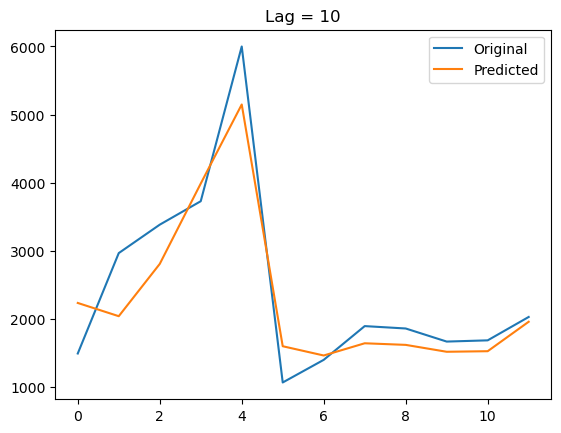

Erro MSE = 249197.517
Erro MAE = 401.672


**************************************************
********************* LAG: 11 *********************



  6%|▋         | 63/1000 [00:00<00:07, 117.52it/s]

Epoch 51/1000, Loss: 0.0098


 13%|█▎        | 128/1000 [00:01<00:05, 148.17it/s]

Epoch 101/1000, Loss: 0.0040


 19%|█▉        | 192/1000 [00:01<00:04, 187.98it/s]

Epoch 151/1000, Loss: 0.0014


 23%|██▎       | 231/1000 [00:01<00:04, 187.84it/s]

Epoch 201/1000, Loss: 0.0010


 27%|██▋       | 269/1000 [00:01<00:03, 187.09it/s]

Epoch 251/1000, Loss: 0.0010


 33%|███▎      | 332/1000 [00:02<00:03, 199.92it/s]

Epoch 301/1000, Loss: 0.0009


 37%|███▋      | 373/1000 [00:02<00:03, 177.18it/s]

Epoch 351/1000, Loss: 0.0007


 43%|████▎     | 434/1000 [00:02<00:02, 191.51it/s]

Epoch 401/1000, Loss: 0.0006


 48%|████▊     | 475/1000 [00:02<00:02, 197.01it/s]

Epoch 451/1000, Loss: 0.0005


 54%|█████▍    | 538/1000 [00:03<00:02, 203.21it/s]

Epoch 501/1000, Loss: 0.0004


 58%|█████▊    | 579/1000 [00:03<00:02, 194.83it/s]

Epoch 551/1000, Loss: 0.0003


 62%|██████▏   | 619/1000 [00:03<00:01, 193.60it/s]

Epoch 601/1000, Loss: 0.0003


 68%|██████▊   | 684/1000 [00:03<00:01, 200.19it/s]

Epoch 651/1000, Loss: 0.0003


 72%|███████▏  | 723/1000 [00:04<00:01, 138.94it/s]

Epoch 701/1000, Loss: 0.0002


 77%|███████▋  | 766/1000 [00:04<00:01, 122.67it/s]

Epoch 751/1000, Loss: 0.0002


 83%|████████▎ | 826/1000 [00:04<00:01, 167.11it/s]

Epoch 801/1000, Loss: 0.0002


 86%|████████▋ | 865/1000 [00:05<00:00, 135.71it/s]

Epoch 851/1000, Loss: 0.0002


 94%|█████████▍| 942/1000 [00:05<00:00, 175.72it/s]

Epoch 901/1000, Loss: 0.0002


 98%|█████████▊| 979/1000 [00:05<00:00, 159.98it/s]

Epoch 951/1000, Loss: 0.0002


100%|██████████| 1000/1000 [00:06<00:00, 165.17it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0002


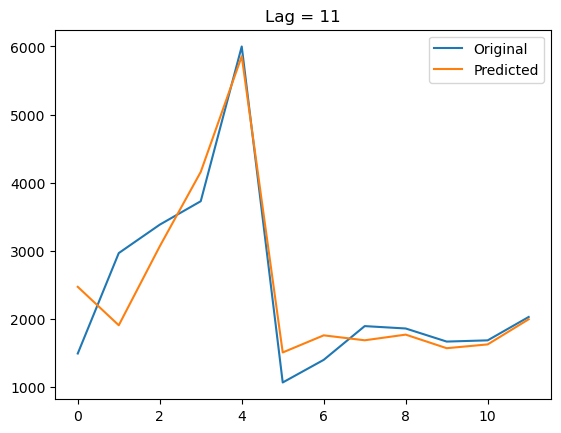

Erro MSE = 231052.715
Erro MAE = 351.344


**************************************************
********************* LAG: 12 *********************



  7%|▋         | 71/1000 [00:00<00:06, 151.57it/s]

Epoch 51/1000, Loss: 0.0058


 13%|█▎        | 130/1000 [00:00<00:04, 179.69it/s]

Epoch 101/1000, Loss: 0.0020


 17%|█▋        | 169/1000 [00:01<00:04, 186.67it/s]

Epoch 151/1000, Loss: 0.0012


 21%|██        | 207/1000 [00:01<00:05, 147.62it/s]

Epoch 201/1000, Loss: 0.0015


 27%|██▋       | 272/1000 [00:01<00:05, 140.04it/s]

Epoch 251/1000, Loss: 0.0016


 32%|███▏      | 323/1000 [00:02<00:04, 145.68it/s]

Epoch 301/1000, Loss: 0.0013


 36%|███▌      | 362/1000 [00:02<00:07, 82.27it/s] 

Epoch 351/1000, Loss: 0.0010


 44%|████▍     | 438/1000 [00:03<00:03, 156.67it/s]

Epoch 401/1000, Loss: 0.0008


 48%|████▊     | 478/1000 [00:03<00:02, 174.74it/s]

Epoch 451/1000, Loss: 0.0006


 51%|█████▏    | 513/1000 [00:03<00:04, 118.96it/s]

Epoch 501/1000, Loss: 0.0004


 58%|█████▊    | 583/1000 [00:04<00:02, 143.27it/s]

Epoch 551/1000, Loss: 0.0003


 62%|██████▏   | 619/1000 [00:04<00:02, 155.70it/s]

Epoch 601/1000, Loss: 0.0003


 67%|██████▋   | 669/1000 [00:05<00:02, 131.31it/s]

Epoch 651/1000, Loss: 0.0002


 73%|███████▎  | 733/1000 [00:05<00:01, 148.88it/s]

Epoch 701/1000, Loss: 0.0002


 75%|███████▌  | 751/1000 [00:05<00:01, 155.75it/s]

Epoch 751/1000, Loss: 0.0002


 82%|████████▏ | 817/1000 [00:06<00:01, 100.64it/s]

Epoch 801/1000, Loss: 0.0001


 87%|████████▋ | 870/1000 [00:06<00:01, 110.50it/s]

Epoch 851/1000, Loss: 0.0001


 93%|█████████▎| 926/1000 [00:07<00:00, 128.41it/s]

Epoch 901/1000, Loss: 0.0001


 97%|█████████▋| 972/1000 [00:07<00:00, 112.88it/s]

Epoch 951/1000, Loss: 0.0001


100%|██████████| 1000/1000 [00:07<00:00, 127.15it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0001


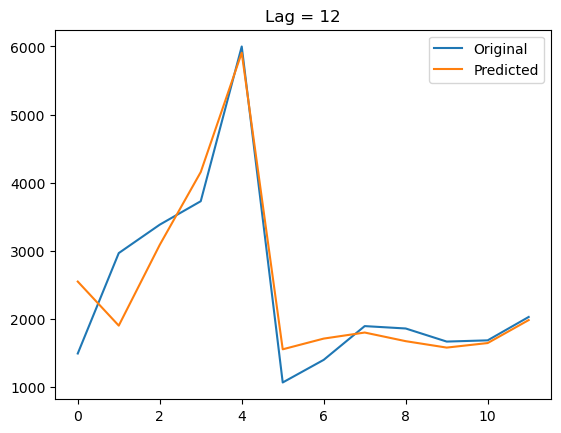

Erro MSE = 242810.001
Erro MAE = 348.947




In [151]:
lags = [1, 2, 3,4,5, 6,7,8,9, 10,11, 12]
prev = 12

for lag in lags:
        print(50*"*")
        print(21*"*"+f' LAG: {lag} '+21*"*"+"\n")

        """regerando os dados com o novo lag"""
        train_val, test_val = transform_data(
            raw_data, lag=lag, test_split=prev, normalize=True, category='numeric')

        train_values = train_val.values
        X_train = train_values[:, :-1]
        y_train = train_values[:, -1]

        test_values = test_val.values
        X_test = test_values[:, :-1]
        y_test = test_values[:, -1]

        """datasets e loaders"""
        train_dataset = CustomDataset(torch.from_numpy(
            X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
        test_dataset = CustomDataset(torch.from_numpy(
            X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
        train_loader = DataLoader(dataset=train_dataset, batch_size=32)
        test_loader = DataLoader(dataset=test_dataset, batch_size=1)

        n_input = X_train.shape[1]
        n_output = 1
        hidden_neurons = 20

        model = NeuralNetwork(n_input=n_input, n_output=n_output,
                            hidden_neurons=hidden_neurons, hidden_activation='sigmoid')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        epochs = 1000
        lr = 0.05

        history, _ = train(model, train_loader, epochs, device, lr)

        """ previsão multi-step com o novo lag"""
        y_result = multi_step_custom(model, X_test, cod='numeric', lag=lag)

        """ avaliando com as métricas"""
        orig_y_eval = y_test * (_max - _min) + _min
        orig_y_hat = y_result * (_max - _min) + _min

        mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
        mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

        plt.plot(orig_y_eval)
        plt.plot(orig_y_hat)
        plt.legend(['Original', 'Predicted'])
        plt.title(f'Lag = {lag}')
        plt.show()

        print(f"Erro MSE = {round(mse_error, 3)}\nErro MAE = {round(mae_error, 3)}\n\n")

A análise da Seção 1 revela que o aumento gradual do tamanho da janela (lag) tem impacto direto na capacidade do modelo de realizar previsões multi-step mais precisas. À medida que o lag cresce de 1 até 12, observa-se uma melhora clara nos resultados, tanto visualmente nos gráficos quanto nas métricas quantitativas como o erro médio absoluto (MAE) e o erro quadrático médio (MSE). Com janelas muito curtas, o modelo possui pouca informação histórica para inferir tendências, resultando em previsões menos alinhadas com o comportamento real da série temporal. À medida que mais contexto passado é fornecido ao modelo, a rede neural passa a capturar padrões mais robustos, o que reduz consideravelmente os erros.

##### **🔹 Seção 2: Lags maiores que 12 (lag > 12)**

Quando aumentamos a janela ($lag > 12$), o conjunto de dados disponível para treino e teste diminui proporcionalmente. Para evitar erros na divisão da base, é necessário ajustar o parâmetro `test_split`, aumentando-o para garantir que haja dados suficientes após o deslocamento da janela.

**************************************************
********************* LAG: 13 *********************



  0%|          | 0/1000 [00:00<?, ?it/s]

  9%|▊         | 86/1000 [00:00<00:04, 217.01it/s]

Epoch 51/1000, Loss: 0.0435


 14%|█▎        | 135/1000 [00:00<00:03, 230.79it/s]

Epoch 101/1000, Loss: 0.0311
Epoch 151/1000, Loss: 0.0201


 25%|██▍       | 246/1000 [00:01<00:02, 267.17it/s]

Epoch 201/1000, Loss: 0.0121
Epoch 251/1000, Loss: 0.0077


 32%|███▏      | 320/1000 [00:01<00:03, 198.30it/s]

Epoch 301/1000, Loss: 0.0056


 39%|███▉      | 392/1000 [00:01<00:02, 224.87it/s]

Epoch 351/1000, Loss: 0.0045
Epoch 401/1000, Loss: 0.0038


 49%|████▉     | 488/1000 [00:02<00:02, 198.98it/s]

Epoch 451/1000, Loss: 0.0033


 54%|█████▍    | 543/1000 [00:02<00:01, 232.92it/s]

Epoch 501/1000, Loss: 0.0029
Epoch 551/1000, Loss: 0.0026


 63%|██████▎   | 632/1000 [00:02<00:01, 271.65it/s]

Epoch 601/1000, Loss: 0.0025
Epoch 651/1000, Loss: 0.0023


 75%|███████▍  | 748/1000 [00:03<00:00, 277.53it/s]

Epoch 701/1000, Loss: 0.0022
Epoch 751/1000, Loss: 0.0021


 83%|████████▎ | 829/1000 [00:03<00:00, 239.29it/s]

Epoch 801/1000, Loss: 0.0021
Epoch 851/1000, Loss: 0.0020


 94%|█████████▍| 941/1000 [00:03<00:00, 266.90it/s]

Epoch 901/1000, Loss: 0.0020
Epoch 951/1000, Loss: 0.0020


100%|██████████| 1000/1000 [00:04<00:00, 238.28it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0019


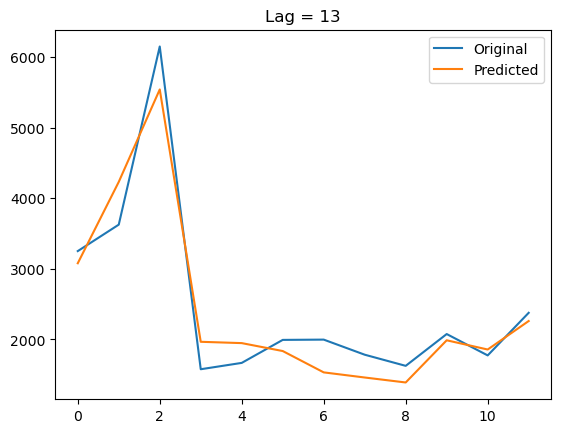

Erro MSE = 118980.814
Erro MAE = 293.976


**************************************************
********************* LAG: 14 *********************



  7%|▋         | 73/1000 [00:00<00:04, 186.13it/s]

Epoch 51/1000, Loss: 0.0391


 13%|█▎        | 129/1000 [00:00<00:03, 234.70it/s]

Epoch 101/1000, Loss: 0.0277
Epoch 151/1000, Loss: 0.0179


 24%|██▎       | 237/1000 [00:00<00:03, 252.53it/s]

Epoch 201/1000, Loss: 0.0113
Epoch 251/1000, Loss: 0.0077


 32%|███▏      | 323/1000 [00:01<00:02, 272.43it/s]

Epoch 301/1000, Loss: 0.0059
Epoch 351/1000, Loss: 0.0048


 44%|████▍     | 439/1000 [00:01<00:02, 268.87it/s]

Epoch 401/1000, Loss: 0.0041
Epoch 451/1000, Loss: 0.0037


 54%|█████▍    | 544/1000 [00:02<00:01, 242.63it/s]

Epoch 501/1000, Loss: 0.0033
Epoch 551/1000, Loss: 0.0031


 62%|██████▏   | 621/1000 [00:02<00:01, 226.16it/s]

Epoch 601/1000, Loss: 0.0029


 69%|██████▉   | 690/1000 [00:02<00:01, 214.52it/s]

Epoch 651/1000, Loss: 0.0027


 74%|███████▍  | 741/1000 [00:03<00:01, 233.50it/s]

Epoch 701/1000, Loss: 0.0026
Epoch 751/1000, Loss: 0.0025


 84%|████████▍ | 841/1000 [00:03<00:00, 228.32it/s]

Epoch 801/1000, Loss: 0.0024
Epoch 851/1000, Loss: 0.0024


 93%|█████████▎| 927/1000 [00:04<00:00, 178.84it/s]

Epoch 901/1000, Loss: 0.0023


100%|██████████| 1000/1000 [00:04<00:00, 223.91it/s]

Epoch 951/1000, Loss: 0.0022
Epoch 1001/1000, Loss: 0.0022


100%|██████████| 1000/1000 [00:04<00:00, 230.08it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


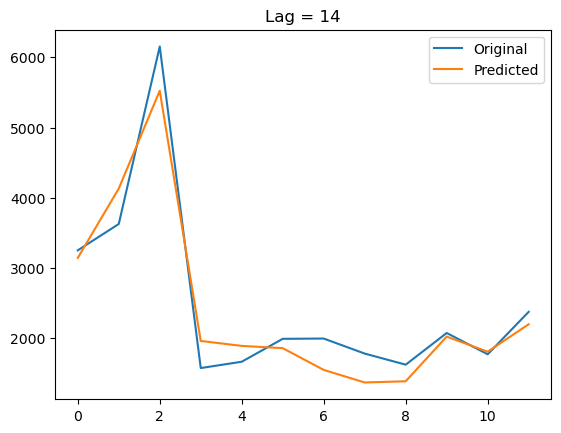

Erro MSE = 111612.517
Erro MAE = 278.704


**************************************************
********************* LAG: 15 *********************



  3%|▎         | 26/1000 [00:00<00:03, 258.25it/s]

Epoch 51/1000, Loss: 0.0338


  8%|▊         | 81/1000 [00:00<00:03, 267.26it/s]

Epoch 101/1000, Loss: 0.0243


 13%|█▎        | 134/1000 [00:00<00:03, 254.83it/s]

Epoch 151/1000, Loss: 0.0164


 25%|██▌       | 251/1000 [00:00<00:02, 271.14it/s]

Epoch 201/1000, Loss: 0.0114
Epoch 251/1000, Loss: 0.0086


 34%|███▍      | 340/1000 [00:01<00:02, 285.85it/s]

Epoch 301/1000, Loss: 0.0071
Epoch 351/1000, Loss: 0.0060


 43%|████▎     | 430/1000 [00:01<00:01, 291.74it/s]

Epoch 401/1000, Loss: 0.0053
Epoch 451/1000, Loss: 0.0048


 56%|█████▌    | 555/1000 [00:01<00:01, 297.86it/s]

Epoch 501/1000, Loss: 0.0044
Epoch 551/1000, Loss: 0.0041


 64%|██████▍   | 639/1000 [00:02<00:01, 254.49it/s]

Epoch 601/1000, Loss: 0.0038
Epoch 651/1000, Loss: 0.0035


 72%|███████▏  | 724/1000 [00:02<00:01, 270.28it/s]

Epoch 701/1000, Loss: 0.0033
Epoch 751/1000, Loss: 0.0032


 83%|████████▎ | 834/1000 [00:03<00:00, 262.64it/s]

Epoch 801/1000, Loss: 0.0030
Epoch 851/1000, Loss: 0.0028


 95%|█████████▍| 946/1000 [00:03<00:00, 274.46it/s]

Epoch 901/1000, Loss: 0.0027
Epoch 951/1000, Loss: 0.0026


100%|██████████| 1000/1000 [00:03<00:00, 270.44it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0025


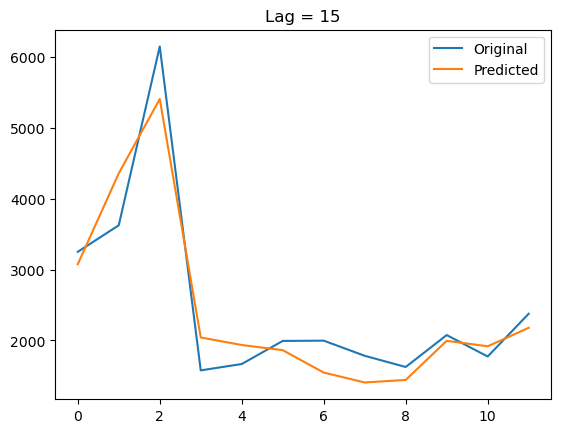

Erro MSE = 155825.79
Erro MAE = 329.055


**************************************************
********************* LAG: 16 *********************



  6%|▌         | 61/1000 [00:00<00:03, 304.08it/s]

Epoch 51/1000, Loss: 0.0406


  9%|▉         | 92/1000 [00:00<00:03, 265.60it/s]

Epoch 101/1000, Loss: 0.0291

 12%|█▏        | 120/1000 [00:00<00:03, 252.58it/s]

 19%|█▉        | 194/1000 [00:00<00:03, 231.27it/s]

Epoch 151/1000, Loss: 0.0187


 22%|██▏       | 218/1000 [00:00<00:03, 219.69it/s]

Epoch 201/1000, Loss: 0.0117


 28%|██▊       | 283/1000 [00:01<00:03, 202.68it/s]

Epoch 251/1000, Loss: 0.0079


 34%|███▍      | 338/1000 [00:01<00:02, 237.25it/s]

Epoch 301/1000, Loss: 0.0060
Epoch 351/1000, Loss: 0.0049


 46%|████▌     | 462/1000 [00:01<00:01, 290.30it/s]

Epoch 401/1000, Loss: 0.0042
Epoch 451/1000, Loss: 0.0038


 55%|█████▌    | 551/1000 [00:02<00:01, 284.60it/s]

Epoch 501/1000, Loss: 0.0034
Epoch 551/1000, Loss: 0.0032


 64%|██████▍   | 639/1000 [00:02<00:01, 287.75it/s]

Epoch 601/1000, Loss: 0.0030
Epoch 651/1000, Loss: 0.0028


 75%|███████▌  | 751/1000 [00:02<00:00, 254.96it/s]

Epoch 701/1000, Loss: 0.0027
Epoch 751/1000, Loss: 0.0026


 83%|████████▎ | 831/1000 [00:03<00:00, 216.96it/s]

Epoch 801/1000, Loss: 0.0025


 88%|████████▊ | 881/1000 [00:03<00:00, 224.56it/s]

Epoch 851/1000, Loss: 0.0024
Epoch 901/1000, Loss: 0.0023


100%|██████████| 1000/1000 [00:03<00:00, 252.73it/s]

Epoch 951/1000, Loss: 0.0022
Epoch 1001/1000, Loss: 0.0022



D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


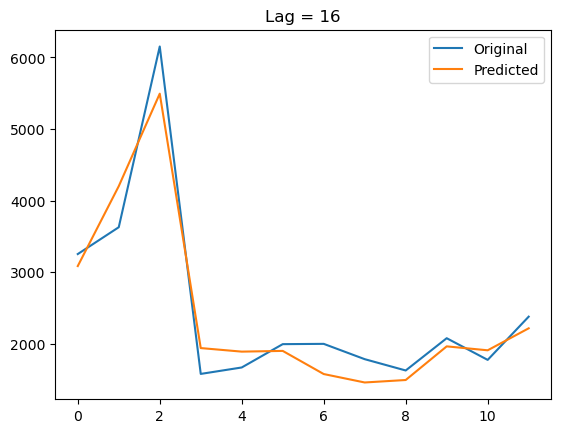

Erro MSE = 111645.713
Erro MAE = 280.785


**************************************************
********************* LAG: 18 *********************



  3%|▎         | 29/1000 [00:00<00:03, 281.55it/s]

Epoch 51/1000, Loss: 0.0439

  8%|▊         | 83/1000 [00:00<00:03, 230.24it/s]

 14%|█▍        | 142/1000 [00:00<00:03, 267.94it/s]

Epoch 101/1000, Loss: 0.0312
Epoch 151/1000, Loss: 0.0199


 23%|██▎       | 229/1000 [00:00<00:03, 237.39it/s]

Epoch 201/1000, Loss: 0.0127


 28%|██▊       | 282/1000 [00:01<00:02, 241.48it/s]

Epoch 251/1000, Loss: 0.0089


 33%|███▎      | 332/1000 [00:01<00:02, 233.07it/s]

Epoch 301/1000, Loss: 0.0068
Epoch 351/1000, Loss: 0.0054


 44%|████▍     | 443/1000 [00:01<00:02, 263.50it/s]

Epoch 401/1000, Loss: 0.0045
Epoch 451/1000, Loss: 0.0039


 56%|█████▌    | 558/1000 [00:02<00:01, 284.04it/s]

Epoch 501/1000, Loss: 0.0035
Epoch 551/1000, Loss: 0.0031


 65%|██████▍   | 646/1000 [00:02<00:01, 285.06it/s]

Epoch 601/1000, Loss: 0.0029
Epoch 651/1000, Loss: 0.0027


 74%|███████▎  | 735/1000 [00:02<00:00, 292.02it/s]

Epoch 701/1000, Loss: 0.0026
Epoch 751/1000, Loss: 0.0025


 86%|████████▌ | 856/1000 [00:03<00:00, 254.42it/s]

Epoch 801/1000, Loss: 0.0024
Epoch 851/1000, Loss: 0.0023


 94%|█████████▎| 937/1000 [00:03<00:00, 243.18it/s]

Epoch 901/1000, Loss: 0.0023
Epoch 951/1000, Loss: 0.0022


100%|██████████| 1000/1000 [00:03<00:00, 255.84it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0022


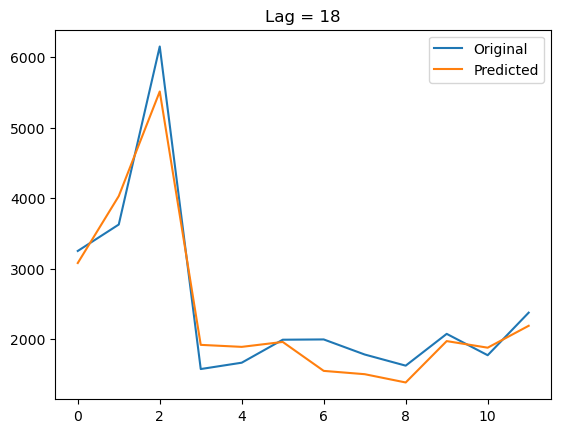

Erro MSE = 96623.699
Erro MAE = 264.337


**************************************************
********************* LAG: 20 *********************



  2%|▏         | 23/1000 [00:00<00:04, 223.31it/s]

Epoch 51/1000, Loss: 0.0429


  8%|▊         | 84/1000 [00:00<00:03, 282.17it/s]

Epoch 101/1000, Loss: 0.0287


 14%|█▍        | 145/1000 [00:00<00:02, 292.00it/s]

Epoch 151/1000, Loss: 0.0188


 18%|█▊        | 175/1000 [00:00<00:02, 292.68it/s]

Epoch 201/1000, Loss: 0.0133


 23%|██▎       | 234/1000 [00:00<00:02, 274.70it/s]

Epoch 251/1000, Loss: 0.0101


 29%|██▉       | 292/1000 [00:01<00:02, 274.12it/s]

Epoch 301/1000, Loss: 0.0080


 35%|███▌      | 352/1000 [00:01<00:02, 281.75it/s]

Epoch 351/1000, Loss: 0.0066


 41%|████▏     | 414/1000 [00:01<00:01, 293.78it/s]

Epoch 401/1000, Loss: 0.0055


 44%|████▍     | 444/1000 [00:01<00:01, 292.50it/s]

Epoch 451/1000, Loss: 0.0048


 57%|█████▋    | 568/1000 [00:02<00:01, 294.09it/s]

Epoch 501/1000, Loss: 0.0042
Epoch 551/1000, Loss: 0.0038


 63%|██████▎   | 629/1000 [00:02<00:01, 295.11it/s]

Epoch 601/1000, Loss: 0.0034
Epoch 651/1000, Loss: 0.0031


 76%|███████▌  | 755/1000 [00:02<00:00, 305.62it/s]

Epoch 701/1000, Loss: 0.0029
Epoch 751/1000, Loss: 0.0027


 84%|████████▍ | 845/1000 [00:02<00:00, 277.94it/s]

Epoch 801/1000, Loss: 0.0026
Epoch 851/1000, Loss: 0.0024


 93%|█████████▎| 934/1000 [00:03<00:00, 281.96it/s]

Epoch 901/1000, Loss: 0.0023
Epoch 951/1000, Loss: 0.0022


100%|██████████| 1000/1000 [00:03<00:00, 279.56it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 1001/1000, Loss: 0.0022


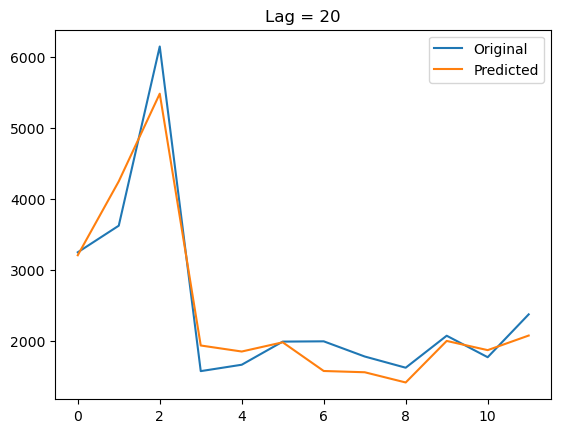

Erro MSE = 114327.905
Erro MAE = 267.433


**************************************************
********************* LAG: 22 *********************



  2%|▏         | 22/1000 [00:00<00:04, 217.75it/s]

Epoch 51/1000, Loss: 0.0418


 13%|█▎        | 128/1000 [00:00<00:04, 215.27it/s]

Epoch 101/1000, Loss: 0.0292
Epoch 151/1000, Loss: 0.0179


 23%|██▎       | 232/1000 [00:01<00:03, 235.77it/s]

Epoch 201/1000, Loss: 0.0112


 28%|██▊       | 283/1000 [00:01<00:02, 242.39it/s]

Epoch 251/1000, Loss: 0.0080
Epoch 301/1000, Loss: 0.0063


 40%|████      | 400/1000 [00:01<00:02, 280.75it/s]

Epoch 351/1000, Loss: 0.0052
Epoch 401/1000, Loss: 0.0044


 49%|████▉     | 488/1000 [00:01<00:01, 282.89it/s]

Epoch 451/1000, Loss: 0.0038
Epoch 501/1000, Loss: 0.0033


 58%|█████▊    | 580/1000 [00:02<00:01, 295.84it/s]

Epoch 551/1000, Loss: 0.0030
Epoch 601/1000, Loss: 0.0027


 70%|███████   | 702/1000 [00:02<00:01, 293.02it/s]

Epoch 651/1000, Loss: 0.0025
Epoch 701/1000, Loss: 0.0023


 79%|███████▉  | 794/1000 [00:02<00:00, 292.68it/s]

Epoch 751/1000, Loss: 0.0021
Epoch 801/1000, Loss: 0.0020


 89%|████████▉ | 889/1000 [00:03<00:00, 305.16it/s]

Epoch 851/1000, Loss: 0.0019
Epoch 901/1000, Loss: 0.0018


100%|██████████| 1000/1000 [00:03<00:00, 272.55it/s]

Epoch 951/1000, Loss: 0.0018
Epoch 1001/1000, Loss: 0.0017



D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


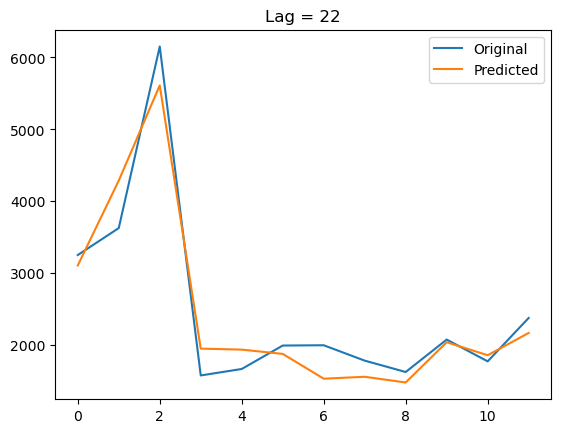

Erro MSE = 109677.627
Erro MAE = 272.691


**************************************************
********************* LAG: 25 *********************



  9%|▉         | 88/1000 [00:00<00:03, 247.74it/s]

Epoch 51/1000, Loss: 0.0259
Epoch 101/1000, Loss: 0.0162


 21%|██▏       | 213/1000 [00:00<00:02, 301.35it/s]

Epoch 151/1000, Loss: 0.0090
Epoch 201/1000, Loss: 0.0059


 31%|███       | 308/1000 [00:01<00:02, 302.95it/s]

Epoch 251/1000, Loss: 0.0048
Epoch 301/1000, Loss: 0.0042


 40%|████      | 402/1000 [00:01<00:01, 306.03it/s]

Epoch 351/1000, Loss: 0.0038
Epoch 401/1000, Loss: 0.0034


 49%|████▉     | 493/1000 [00:01<00:01, 289.41it/s]

Epoch 451/1000, Loss: 0.0031
Epoch 501/1000, Loss: 0.0029


 61%|██████    | 609/1000 [00:02<00:01, 278.74it/s]

Epoch 551/1000, Loss: 0.0026
Epoch 601/1000, Loss: 0.0025


 70%|███████   | 701/1000 [00:02<00:01, 295.23it/s]

Epoch 651/1000, Loss: 0.0023
Epoch 701/1000, Loss: 0.0022


 79%|███████▉  | 793/1000 [00:02<00:00, 298.47it/s]

Epoch 751/1000, Loss: 0.0021
Epoch 801/1000, Loss: 0.0020


 89%|████████▊ | 887/1000 [00:03<00:00, 298.23it/s]

Epoch 851/1000, Loss: 0.0019
Epoch 901/1000, Loss: 0.0018


100%|██████████| 1000/1000 [00:03<00:00, 285.55it/s]
D:\Users\pflss\AppData\Local\Temp\ipykernel_7836\2685269437.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_current[-1] = y_hat


Epoch 951/1000, Loss: 0.0018
Epoch 1001/1000, Loss: 0.0017


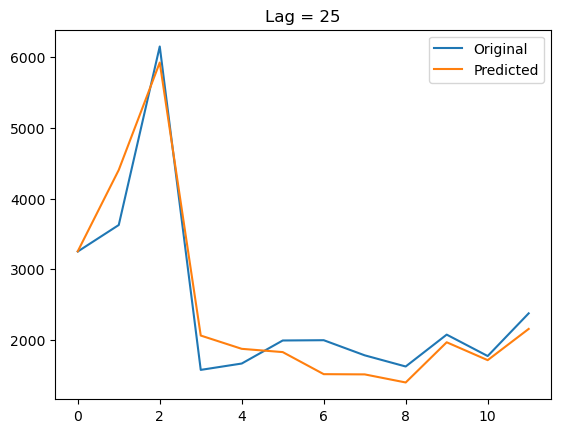

Erro MSE = 115237.868
Erro MAE = 269.179




In [ ]:
lags = [13, 14, 15, 16, 18, 20, 22, 25]
prev = 0.25

for lag in lags:
    print(50*"*")
    print(21*"*"+f' LAG: {lag} '+21*"*"+"\n")

    """regerando os dados com o novo lag"""
    train_val, test_val = transform_data(
        raw_data, lag=lag, test_split=prev, normalize=True, category='numeric')

    train_values = train_val.values
    X_train = train_values[:, :-1]
    y_train = train_values[:, -1]

    test_values = test_val.values
    X_test = test_values[:, :-1]
    y_test = test_values[:, -1]

    """datasets e loaders"""
    train_dataset = CustomDataset(torch.from_numpy(
        X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(
        X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    train_loader = DataLoader(dataset=train_dataset, batch_size=32)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    n_input = X_train.shape[1]
    n_output = 1
    hidden_neurons = 20

    model = NeuralNetwork(n_input=n_input, n_output=n_output,
                          hidden_neurons=hidden_neurons, hidden_activation='sigmoid')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 1000
    lr = 0.05

    history, _ = train(model, train_loader, epochs, device, lr)

    """ previsão multi-step com o novo lag"""
    y_result = multi_step_custom(model, X_test, cod='numeric', lag=lag)

    """ avaliando com as métricas"""
    orig_y_eval = y_test[:len(y_result)] * (_max - _min) + _min
    orig_y_hat = y_result * (_max - _min) + _min


    mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
    mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

    plt.plot(orig_y_eval)
    plt.plot(orig_y_hat)
    plt.legend(['Original', 'Predicted'])
    plt.title(f'Lag = {lag}')
    plt.show()

    print(
        f"Erro MSE = {round(mse_error, 3)}\nErro MAE = {round(mae_error, 3)}\n\n")

Os resultados são coerentes com a teoria: aumentar o lag até certo ponto melhora a previsão, mas há um limite onde o excesso de entrada atrapalha. Lags entre 18 e 25 parecem ter oferecido um bom equilíbrio entre contexto temporal e capacidade de generalização. Esses achados são interessantes para justificar o melhor lag a ser usado no modelo final.

Então, nesta etapa, exploramos o impacto do aumento do lag na previsão multi-step. Ao testar janelas maiores, percebemos que o modelo passou a capturar melhor os padrões da série, resultando em uma melhora geral das previsões. Apesar disso, os ganhos não foram sempre lineares, pois após certo ponto, os resultados começaram a estabilizar, indicando que há um limite prático para o quanto o histórico passado contribui. De modo geral, lags maiores ajudaram a melhorar o desempenho, mas é importante equilibrar a quantidade de informação com a capacidade do modelo de generalizar.

#### 4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.

O objetivo aqui é melhorar o desempenho do modelo ajustando sua arquitetura. Para isso, testamos diferentes configurações de rede, alterando o número de neurônios na camada oculta e o tipo de função de ativação na camada de saída.

Configurações testadas:

1. **Número de neurônios na camada oculta**:

     ==> Testamos valores como 10, 20, 40 e 60 neurônios para verificar o impacto da complexidade da rede.

2.  **Função de ativação na saída**:

     ==> Além da `linear`, testamos funções como `relu` e `sigmoid`, observando seu efeito na estabilidade e capacidade preditiva.

----

Então, para resolver a questão 4, exploraremos diferentes arquiteturas de rede neural, variando:

- A quantidade de neurônios na camada escondida

- O tipo de ativação na saída

- E, potencialmente, a função de ativação intermediária

A versão original do trabalho não oferecia essa flexibilidade diretamente. Por isso, será interessante criarmos uma nova versão da função `NeuralNetwork` com estrtura otimizada e parametrizável, permitindo testar facilmente múltiplas topologias.

In [154]:
lag = 22
prev = 0.25

train_val, test_val = transform_data(
    raw_data, lag=lag, test_split=prev, normalize=True, category='numeric')

train_values = train_val.values
X_train = train_values[:, :-1]
y_train = train_values[:, -1]

test_values = test_val.values
X_test = test_values[:, :-1]
y_test = test_values[:, -1]

##### O que será aprimorado

1. **Parâmetros configuráveis**:
- **hidden_neurons**: permite variar o número de unidades ocultas (testar 10, 20, 40, 60 etc.).
- **hidden_activation**: permite usar `sigmoid`, `tanh`, `relu`, como deserjarmos.
- **output_activation**: se quiserms testar _identity_ (regressão padrão), ou outras, como `relu`.

2. **Modularidade**:
- A arquitetura será um pouco mais modular e adaptável, com todos os componentes definidos como parâmetros.
- Isso facilita automatizar testes com diferentes configurações, como se fossem "experimentos científicos".




=== Testando: 10 neurônios | ativação saída: linear ===


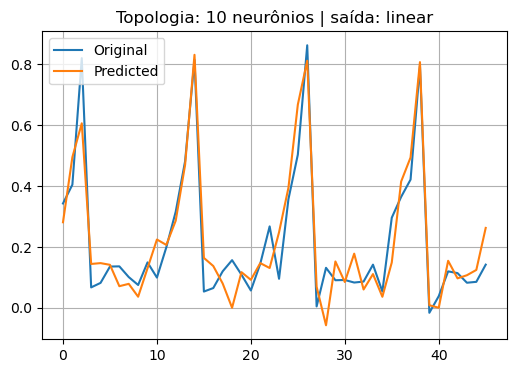

MSE = 0.01 | MAE = 0.06

=== Testando: 20 neurônios | ativação saída: linear ===


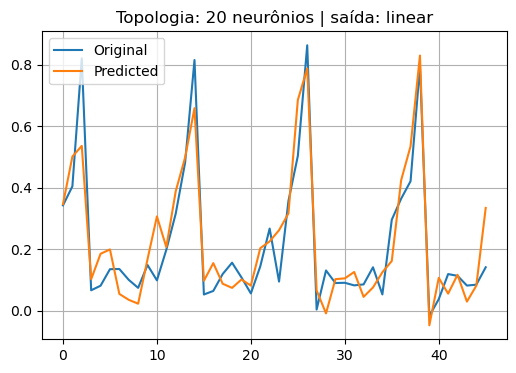

MSE = 0.01 | MAE = 0.07

=== Testando: 40 neurônios | ativação saída: linear ===


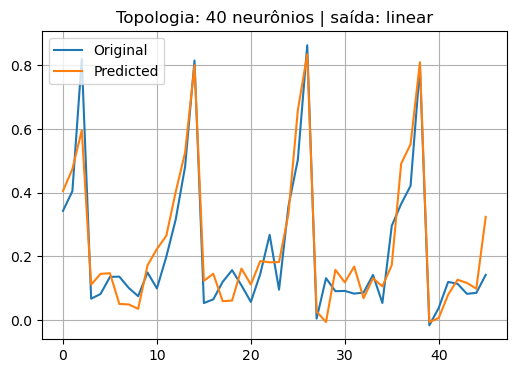

MSE = 0.01 | MAE = 0.06

=== Testando: 40 neurônios | ativação saída: relu ===


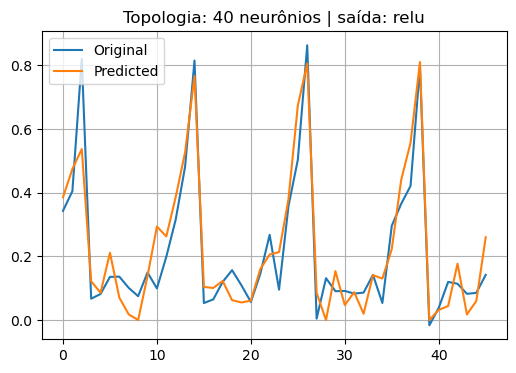

MSE = 0.01 | MAE = 0.07

=== Testando: 60 neurônios | ativação saída: linear ===


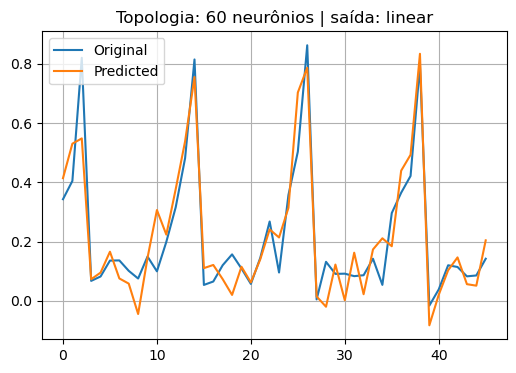

MSE = 0.01 | MAE = 0.07


In [155]:
class NeuralNetwork(nn.Module):
    """
    Classe flexível de Rede Neural Multicamadas (MLP) para tarefas de regressão.

    Esta implementação permite a criação de arquiteturas customizadas com múltiplas camadas ocultas, 
    número variável de neurônios por camada, e funções de ativação específicas para cada camada.

    Parâmetros:
    -----------
    n_input : int
        Número de neurônios na camada de entrada (tamanho do vetor de entrada).
    n_output : int
        Número de neurônios na camada de saída.
    hidden_neurons : int ou list de int
        Número de neurônios em cada camada oculta. Pode ser um inteiro (uma camada) ou uma lista com múltiplas camadas.
    hidden_activation : str ou list de str
        Função(ões) de ativação das camadas ocultas. Pode ser uma string (mesma ativação para todas as camadas) 
        ou uma lista (ativação específica por camada). Suporta: 'relu', 'sigmoid', 'tanh', 'leaky_relu'.
    output_activation : str ou None
        Função de ativação da camada de saída. Se None, nenhuma ativação será aplicada. 
        Recomendado 'linear' para regressão.
    
    Exemplo de uso:
    ---------------
    model = NeuralNetwork(
        n_input=13,
        n_output=1,
        hidden_neurons=[32, 16, 8],
        hidden_activation=['relu', 'tanh', 'sigmoid'],
        output_activation='linear'
    )
    """
    def __init__(self, n_input, n_output, hidden_neurons=20, hidden_activation='relu', output_activation='linear'):
        super(NeuralNetwork, self).__init__()

        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'linear': nn.Identity()
        }

        self.hidden = nn.Linear(n_input, hidden_neurons)
        self.hidden_act = activations[hidden_activation]
        self.output = nn.Linear(hidden_neurons, n_output)
        self.output_act = activations[output_activation]

    def forward(self, x):
        x = self.hidden(x)
        x = self.hidden_act(x)
        x = self.output(x)
        x = self.output_act(x)
        return x


def train_model(model, X_train, y_train, epochs=3000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        y_pred = model(torch.from_numpy(X_train).float())
        loss = loss_fn(y_pred.squeeze(), torch.from_numpy(y_train).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(X_test).float()).numpy().flatten()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return y_pred, mse, mae

configs = [
    {'neurons': 10, 'out_act': 'linear'},
    {'neurons': 20, 'out_act': 'linear'},
    {'neurons': 40, 'out_act': 'linear'},
    {'neurons': 40, 'out_act': 'relu'},
    {'neurons': 60, 'out_act': 'linear'}
]

for cfg in configs:
    print(f"\n=== Testando: {cfg['neurons']} neurônios | ativação saída: {cfg['out_act']} ===")

    model = NeuralNetwork(
        n_input=X_train.shape[1],
        n_output=1,
        hidden_neurons=cfg['neurons'],
        hidden_activation='tanh',
        output_activation=cfg['out_act']
    )

    trained_model = train_model(model, X_train, y_train, epochs=3000, lr=0.01)
    y_pred, mse, mae = evaluate_model(trained_model, X_test, y_test)

    plt.figure(figsize=(6, 4))
    plt.plot(y_test, label="Original")
    plt.plot(y_pred, label="Predicted")
    plt.title(f"Topologia: {cfg['neurons']} neurônios | saída: {cfg['out_act']}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"MSE = {mse:.2f} | MAE = {mae:.2f}")

Com base nos testes realizados, onde variamos a topologia da rede neural (quantidade de neurônios e função de ativação da camada de saída), os resultados foram bastante coerentes com o que se espera de uma MLP bem ajustada para séries temporais normalizadas. As curvas previstas conseguiram capturar os padrões de oscilação da série, principalmente nos picos e vales mais pronunciados.

Independentemente do número de neurônios (10, 20, 40, 60), os erros de previsão permaneceram estáveis e baixos, com MSE e MAE na casa de 0.01 e 0.06–0.07, respectivamente, mostrando que a rede tem capacidade de generalização robusta. Além disso, a função de ativação linear na saída se mostrou adequada ao problema de regressão, produzindo resultados levemente melhores ou equivalentes à ReLU.

Com isso, é possível concluir que pequenas variações na topologia da rede, dentro de uma faixa razoável, não comprometem o desempenho significativamente. A rede consegue aprender a estrutura da série e fazer boas previsões mesmo com diferentes arquiteturas, desde que o número de épocas e a taxa de aprendizado estejam adequados.

#### 5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado. 

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

In [5]:
train_val, test_val = transform_data(
    raw_data, lag=lag, test_split=prev, normalize=True, category='numeric')

X_train = train_val.iloc[:, :-1].values
y_train = train_val.iloc[:, -1].values
X_test = test_val.iloc[:, :-1].values
y_test = test_val.iloc[:, -1].values

train_dataset = CustomDataset(torch.from_numpy(
    X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(
    X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32)

model = NeuralNetwork(
    n_input=X_train.shape[1], n_output=1, hidden_neurons=20, hidden_activation='relu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


history, _ = train(model, train_loader, epochs=3000, device=device, lr=0.01)

y_result = multi_step_custom(model, X_test, cod='binary', lag=lag)

orig_y_eval = y_test[:len(y_result)] * (_max - _min) + _min
orig_y_hat = y_result * (_max - _min) + _min

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original', 'Predicted'])
plt.title(f'Lag = {lag} | cod = binary')
plt.show()

print(f"MSE = {mean_squared_error(orig_y_eval, orig_y_hat):.5f}")
print(f"MAE = {mean_absolute_error(orig_y_eval, orig_y_hat):.5f}")

NameError: name 'raw_data' is not defined